In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
# import pickle as pk
import pytz
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
from os import path
import sys
from mmctools.plotting import TaylorDiagram
from scipy.stats import pearsonr
import glob
from mmctools.wrf.utils import tsout_seriesReader
from mmctools.helper_functions import calc_wind,w_s,theta_to_T
from matplotlib.colors import Normalize
from string import ascii_lowercase
from matplotlib.legend_handler import HandlerBase
import matplotlib.gridspec as gridspec
import matplotlib
from matplotlib.ticker import MaxNLocator

In [3]:
main_directory = '/glade/scratch/hawbecke/WRF/MMC/NYSERDA/SENSITIVITY_SUITE/production/'
#main_directory = '/glade/work/hawbecke/MMC/NYSERDA/WRF/SENSITIVITY_SUITE/'

#obs_shift = '160min'
obs_shift = '0min'

if obs_shift == '0min':
    save_dir = '/glade/work/hawbecke/MMC/NYSERDA/WRF/SENSITIVITY_SUITE/production/img/'
else:
    save_dir = '/glade/work/hawbecke/MMC/NYSERDA/WRF/SENSITIVITY_SUITE/production/img/obs_shift/'

save_figs = False

icbc_type = 'MERRA2'  # ERAI, ERA5, FNL

from NYSERDA_case_dict import case_dict

cases = [case_dict[x]['case_str'] for x in list(case_dict.keys())]

# TESTING:
#cases = [cases[0]] + cases[3:6]# + [cases[-1]]
# SST Only:
cases = cases[:-2]

eta_level_testing = False
if eta_level_testing:
    main_directory += 'eta_level_test/'
    cases = cases[-3:]
    time_step = 5.0
else:
    cases = cases[:]
    failed_cases = []
    for case in failed_cases:
        cases.remove(case)
    time_step = 6.0

sim_start = '2020-04-04 06:00:00'
#case_start = '2020-04-05 16:00:00'
#case_end   = '2020-04-06 06:00:00'
case_start = '2020-04-06 02:00:00'
case_end   = '2020-04-06 06:00:00'

best_case  = 'WPS3_WRF1'
n_profiles = 8


# Colors for spread (red) and EME (blue)
meso_spread = 'lightcoral'
les_spread = 'darkred'
meso_eme = 'skyblue'
les_eme = 'royalblue'

dom_dict = {1: {'dt':15,
                #'color':'violet',
                'color':'lightcoral',
                'marker': r'$ 1 $',
                'ls':'-'},
            2: {'dt':5,
                #'color':'deeppink',
                'color':'darkred',
                'marker': r'$ 2 $',
                'ls':'--'},
            3: {'dt':1,
                'color':'g',
                'marker': r'$ 3 $',
                'ls':'-'},
            4: {'dt':0.2,
                #'color':'turquoise',
                'color':'skyblue',
                'marker': r'$ 4 $',
                'ls':'-.'},
            5: {'dt':0.04,
                #color':'steelblue',
                'color':'royalblue',
                'marker': r'$ 5 $',
                'ls':':'},
            }
#doms_of_interest = [1,2,3,4,5]
doms_of_interest = [1,2,4,5]

#for cc,case in enumerate(cases):
#    plt.plot(np.arange(0,10),np.arange(0,10)*cc,c=case_dict[case]['color'])

twr_lat = [ 39.969278,  39.546772]
twr_lon = [-72.716692, -73.428892]
twr_names = ['E05','E06']
twr_abbreviation = ['E05','E06']

uniform_wspd_min = 6.0
uniform_wspd_max = 19.0


variable_dict = {'low_shear':{'title':'Low-Level Shear','units':'s$^{-1}$'},
                 'hub_wspd':{'title':'Hub-Height Wind Speed','units':'m s$^{-1}$'},
                 'llj_height':{'title':'LLJ Nose Height','units':'m'},
                 'max_wspd':{'title':'Max Windspeed','units':'m s$^{-1}$'},
                 'delT':{'title':'$\Delta$T','units':'K'},
                 't2':{'title':'2 m Temperature','units':'K'},
                 'tsk':{'title':'SST','units':'K'},
                 'rews':{'title':'REWS','units':'[m s$^{-1}$]'},
                }

hub_height = 118.0 # 98.0 or 118.0
rotor_D = 160.0

In [4]:
marker_dict = {}
use_letters = False
markers = ['o','*','^','s','p','P','X','d','v']
for cc,case in enumerate(list(case_dict.keys())):
    if use_letters:
        m = case_dict[case]['case_name'][0]
        if '${}$'.format(m) in marker_dict.values():
            for i in case_dict[case]['case_name'][1:]:
                if '${}$'.format(i) not in marker_dict.values():
                    m = i
        marker = '${}$'.format(m)
    else:
        marker = markers[cc]
    marker_dict[case] = marker


# Get Obs:

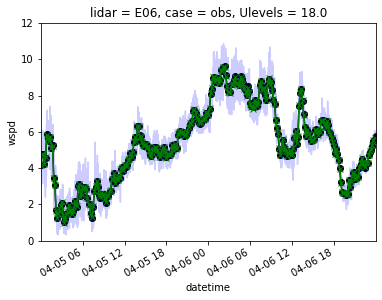

In [5]:
obs_dir = '/glade/work/hawbecke/MMC/NYSERDA/obs/'
obs_res = 'high' # 'low' or 'high'
atlshrs_full = xr.open_dataset('{}ATLSHORES_lidars.nc'.format(obs_dir))
atlshrs_obs = atlshrs_full.sel(case='obs').squeeze(dim='Tlevels')
atlshrs_obs.T.data += 273.15
atlshrs_obs.sst.data += 273.15

if obs_res == 'low':
    nyserda_full = xr.open_dataset('{}NYSERDA_lidars.nc'.format(obs_dir))
    nyserda_obs = nyserda_full.sel(case='obs')
    
    #best_case = 'WPS3_WRF1'
    #nyserda_opt = nyserda_full.sel(case=best_case)
    hr_nyserda_obs = xr.open_dataset('{}HR_NYSERDA_lidars.nc'.format(obs_dir))
else:
    lr_nyserda_obs = xr.open_dataset('{}NYSERDA_lidars.nc'.format(obs_dir))
    lr_nyserda_obs = lr_nyserda_obs.sel(case='obs',Tlevels=2).drop('Tlevels')

    nyserda_obs = xr.open_dataset('{}HR_NYSERDA_lidars.nc'.format(obs_dir))
    nyserda_obs = nyserda_obs.drop('T')
    nyserda_obs = nyserda_obs.squeeze().drop('Tlevels')

    sst = lr_nyserda_obs.sst.sel(datetime=slice(nyserda_obs.datetime[0],nyserda_obs.datetime[-1]))
    nyserda_obs = xr.merge([nyserda_obs,sst])
    t2 = lr_nyserda_obs.T.sel(datetime=slice(nyserda_obs.datetime[0],nyserda_obs.datetime[-1])).squeeze()
    nyserda_obs = xr.merge([nyserda_obs,t2])

    lr_nyserda_obs.wspd.sel(Ulevels=20,lidar='E06').plot(c='k',marker='o')
    nyserda_obs.wspd.sel(Ulevels=18,lidar='E06').dropna(how='any',dim='datetime').plot(c='b',alpha=0.2)
    nyserda_obs.wspd.sel(Ulevels=18,lidar='E06').resample({'datetime':'10min'}).mean().plot(c='g',marker='x')
    plt.xlim(pd.to_datetime(nyserda_obs.datetime.data[0]),pd.to_datetime(nyserda_obs.datetime.data[-1]))
    plt.ylim(0,12)

/glade/u/home/hawbecke/local/envs/mmc/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


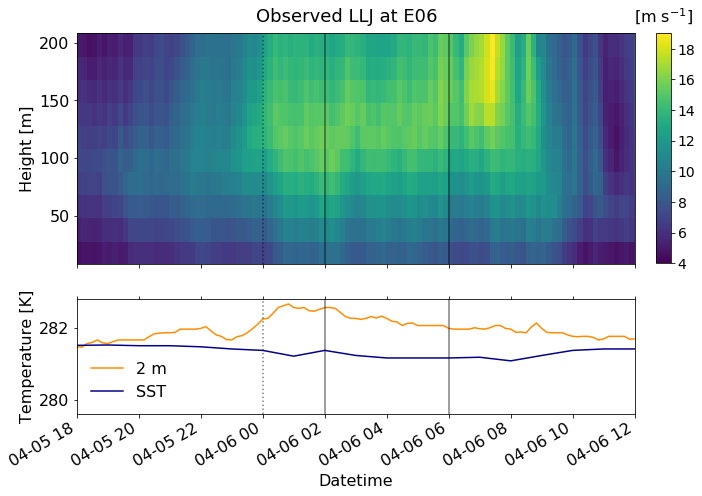

In [6]:
add_profiles = False

fig,ax = plt.subplots(nrows=2,figsize=(10,7),sharex=True,gridspec_kw={'height_ratios': [2, 1]})

resampled_obs = nyserda_obs.resample({'datetime':'10min'}).mean()


plt_levels = resampled_obs.Ulevels.data

plt_levels = 0.5*(plt_levels[1:] + plt_levels[:-1])

dz = np.mean(plt_levels[1:] - plt_levels[:-1])

plt_levels = [plt_levels[0] - dz] + list(plt_levels) + [plt_levels[-1] + dz]

wspd_plt = ax[0].pcolormesh(resampled_obs.datetime,
                            plt_levels,
                            resampled_obs.wspd.T.sel(lidar='E06'),
                            rasterized=True,
                            vmin=4.0,
                            vmax=19.0)

resampled_obs.sel(lidar='E06').T.dropna(how='any',dim='datetime').plot(ax=ax[1],c='darkorange',label='2 m')
resampled_obs.sel(lidar='E06').sst.dropna(how='any',dim='datetime').plot(ax=ax[1],c='darkblue',label='SST')

for axi in range(0,2):
    ax[axi].set_xlim(pd.to_datetime('2020-04-05 18:00'),pd.to_datetime('2020-04-06 12:00'))
    ax[axi].tick_params(labelsize=16)
    ax[axi].set_title('')
    ax[axi].axvline(pd.to_datetime('2020-04-06 00:00'),c='k',ls=':',alpha=0.5)
    ax[axi].axvline(pd.to_datetime(case_start),c='k',ls='-',alpha=0.5)
    ax[axi].axvline(pd.to_datetime(case_end),c='k',ls='-',alpha=0.5)
    
ax[1].tick_params(top=True)
ax[0].set_ylabel('Height [m]',size=16)
ax[1].set_ylabel('Temperature [K]',size=16)

cax  = fig.add_axes([0.93,0.424,0.02,0.456])
cbar = plt.colorbar(wspd_plt,cax=cax)
cbar.ax.tick_params(labelsize=14)
cbar.ax.set_title('[m s$^{-1}$]',size=16,y=1.02)

if add_profiles:
    plt.draw()
    xticks = ax[1].get_xticklabels()
    xtick_times = []
    for tt,ticktime in enumerate(xticks):
        ttime = '2020-{}:00:00'.format(ticktime.get_text())
        xtick_times += [pd.to_datetime(ttime)]

    wspd_profiles = nyserda_obs.wspd.sel(lidar='E06').dropna(how='all',dim='datetime').sel(datetime=xtick_times,method='nearest')

    wax = ax[0].twiny()
    wspd_profiles -= wspd_profiles.isel(Ulevels=0)
    wspd_profiles /= 10
    wspd_profiles = wspd_profiles + np.arange(0,len(xtick_times))
    for dtime in wspd_profiles.datetime[:-1]:
        wspd_profiles.sel(datetime=dtime).dropna(how='any',dim='Ulevels').plot(y='Ulevels',ax=wax,c='lightblue')

    for vline in range(0,10):
        wax.axvline(vline,c='k',alpha=0.5,ls=':')
    wax.set_xlim(0,9)
    wax.tick_params(labeltop=False,top=False)
    wax.set_title('')
ax[0].set_xlabel('')
ax[1].set_xlabel('Datetime',size=16)
ax[1].legend(frameon=False,fontsize=16)
plt.suptitle('Observed LLJ at E06',size=18,y=0.93)

if obs_shift != '0min':
    for axi in range(0,2):
        ax[axi].axvline(pd.to_datetime('2020-04-06 00:00')+pd.Timedelta(obs_shift),c='r',ls=':',alpha=0.5,lw=2.0)
        ax[axi].axvline(pd.to_datetime(case_start)+pd.Timedelta(obs_shift),c='r',ls='-',alpha=0.5,lw=2.0)
        ax[axi].axvline(pd.to_datetime(case_end)+pd.Timedelta(obs_shift),c='r',ls='-',alpha=0.5,lw=2.0)
fig_name = '{}E06Obs_10min'.format(save_dir)
if add_profiles:
    fig_name += '_withProfiles'
if save_figs: 
    for save_type in ['.png','.pdf']: plt.savefig(fig_name+save_type,bbox_inches='tight')
plt.show()

# Domains:

In [7]:
wrfin_list = sorted(glob.glob('{}{}/wrfin*'.format(main_directory,cases[0])))
wrfin_dict = {}
for ff,wrfin_f in enumerate(wrfin_list):
    wrfin_dict['d0{}'.format(ff+1)] = xr.open_dataset(wrfin_f).squeeze()
    

In [8]:
def labelAtEdge(levels, cs, ax, fmt, side='both', pad=0.005, **kwargs):
    '''Label contour lines at the edge of plot
    Args:
        levels (1d array): contour levels.
        cs (QuadContourSet obj): the return value of contour() function.
        ax (Axes obj): matplotlib axis.
        fmt (str): formating string to format the label texts. E.g. '%.2f' for
            floating point values with 2 demical places.
    Keyword Args:
        side (str): on which side of the plot intersections of contour lines
            and plot boundary are checked. Could be: 'left', 'right', 'top',
            'bottom' or 'all'. E.g. 'left' means only intersections of contour
            lines and left plot boundary will be labeled. 'all' means all 4
            edges.
        pad (float): padding to add between plot edge and label text.
        **kwargs: additional keyword arguments to control texts. E.g. fontsize,
            color.
    '''
    from matplotlib.transforms import Bbox
    collections = cs.collections
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    bbox = Bbox.from_bounds(xlim[0], ylim[0], xlim[1]-xlim[0], ylim[1]-ylim[0])
    eps = 1e-5  # error for checking boundary intersection
    # -----------Loop through contour levels-----------
    for ii, lii in enumerate(levels):
        cii = collections[ii]  # contours for level lii
        pathsii = cii.get_paths()  # the Paths for these contours
        if len(pathsii) == 0:
            continue
        for pjj in pathsii:
            # check first whether the contour intersects the axis boundary
            if not pjj.intersects_bbox(bbox, False):  # False significant here
                continue
            xjj = pjj.vertices[:, 0]
            yjj = pjj.vertices[:, 1]
            # intersection with the left edge
            if side in ['left', 'all']:
                inter_idx = np.where(abs(xjj-xlim[0]) <= eps)[0]
                for kk in inter_idx:
                    inter_x = xjj[kk]
                    inter_y = yjj[kk]
                    ax.text(inter_x-pad, inter_y, fmt % lii,
                            ha='right',
                            va='center',
                            **kwargs)
            # intersection with the right edge
            if side in ['right', 'all']:
                inter_idx = np.where(abs(xjj-xlim[1]) <= eps)[0]
                for kk in inter_idx:
                    inter_x = xjj[kk]
                    inter_y = yjj[kk]
                    ax.text(inter_x+pad, inter_y, fmt % lii,
                            ha='left',
                            va='center',
                            **kwargs)
            # intersection with the bottom edge
            if side in ['bottom', 'all']:
                inter_idx = np.where(abs(yjj-ylim[0]) <= eps)[0]
                for kk in inter_idx:
                    inter_x = xjj[kk]
                    inter_y = yjj[kk]
                    ax.text(inter_x, inter_y-pad, fmt % lii,
                            ha='center',
                            va='top',
                            **kwargs)
            # intersection with the top edge
            if side in ['top', 'all']:
                inter_idx = np.where(abs(yjj-ylim[-1]) <= eps)[0]
                for kk in inter_idx:
                    inter_x = xjj[kk]
                    inter_y = yjj[kk]
                    ax.text(inter_x, inter_y+pad, fmt % lii,
                            ha='center',
                            va='bottom',
                            **kwargs)
    return

def domain_plot(axi,domain_s,domain_e,number_lat_ticks=6,number_lon_ticks=6):
    pgr = 1
    i_s,j_s = 0,0
    for dom in range(domain_s,+domain_e+1):
        wrf_lat = wrfin_dict['d0{}'.format(dom)].XLAT
        wrf_lon = wrfin_dict['d0{}'.format(dom)].XLONG
        wrf_hgt = wrfin_dict['d0{}'.format(dom)].HGT
        wrf_sst = wrfin_dict['d0{}'.format(dom)].SST
        wrf_landmask = wrfin_dict['d0{}'.format(dom)].LANDMASK

        if dom == domain_s:
            min_lat = float(np.round(wrf_lat.min()))
            max_lat = float(wrf_lat.max())
            lat_span = max_lat - min_lat
            
            min_lon = float(np.round(wrf_lon.min()))
            max_lon = float(wrf_lon.max())
            lon_span = max_lon - min_lon
            
            if (lon_span < 10.0) or (lat_span < 10.0):
                num_dec = 1
            else:
                num_dec = 0
                
            lat_int = np.round(lat_span / number_lat_ticks, decimals=num_dec)
            lon_int = np.round(lon_span / number_lon_ticks,decimals=num_dec)

            #plt.contourf(wrf_hgt.where(wrf_landmask==1.0),cmap=plt.cm.terrain,alpha=0.25)
            #plt.contourf(wrf_sst.where(wrf_landmask==0.0),cmap=plt.cm.viridis,alpha=0.5,linewidths=None)
            axi.contourf(wrf_landmask,colors='lightgreen',levels=[0.5,1.0],alpha=0.5)
            axi.contourf(wrf_landmask,colors='lightskyblue',levels=[0.0,0.5],alpha=0.5)
            axi.contour(wrf_landmask,colors='grey',levels=[0.5],alpha=0.5)
            lat_cs = axi.contour(wrf_lat,levels=np.arange(min_lat,max_lat,lat_int),
                                 colors='k',alpha=0.25)

            lon_cs = axi.contour(wrf_lon,levels=np.arange(min_lon,max_lon,lon_int),
                                 colors='k',alpha=0.25,linestyles='solid')
            lat_levels = lat_cs.levels
            lon_levels = lon_cs.levels

            axi.tick_params(left=False,bottom=False,labelsize=0)
            labelAtEdge(lat_levels, lat_cs, axi, r'%.1f', side='left', pad=2,size=16)
            labelAtEdge(lon_levels, lon_cs, axi, r'%.1f', side='bottom', pad=5,size=16)
            axi.set_ylabel('Latitude',size=18,labelpad=40)
            axi.set_xlabel('Longitude',size=18,labelpad=20)
            axi.set_aspect('equal')

        else:
            i_s += wrfin_dict['d0{}'.format(dom)].I_PARENT_START/pgr
            j_s += wrfin_dict['d0{}'.format(dom)].I_PARENT_START/pgr
            pgr *= wrfin_dict['d0{}'.format(dom)].PARENT_GRID_RATIO

            n_x = len(wrfin_dict['d0{}'.format(dom)].west_east)/pgr
            n_y = len(wrfin_dict['d0{}'.format(dom)].south_north)/pgr

            dom_x = [i_s,i_s+n_x,i_s+n_x,i_s,i_s]
            dom_y = [j_s,j_s,j_s+n_y,j_s+n_y,j_s]
            axi.plot(dom_x,dom_y,c='k')
            axi.text((2*i_s+n_x)*0.5,j_s+n_y+5,'d0{}'.format(dom),size=18,ha='center')



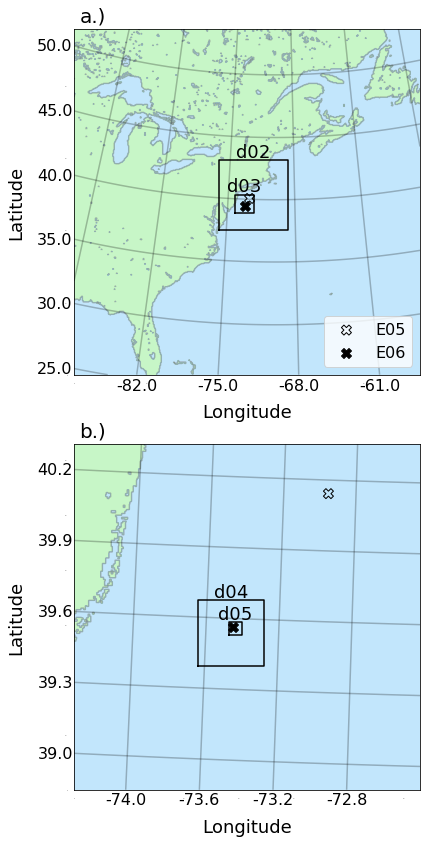

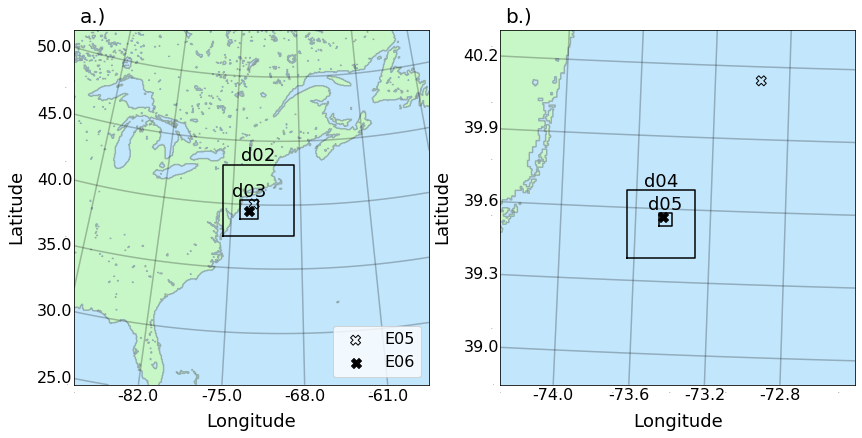

In [9]:
for fig_type in ['vert','horz']:

    if fig_type == 'vert':
        nrows = 2
        ncols = 1
        figsize = (7,14)
    else:
        nrows = 1
        ncols = 2
        figsize = (14,7)

        
    fig,ax = plt.subplots(nrows=nrows,ncols=ncols,figsize=figsize)
    domain_plot(ax[0],1,3)
    domain_plot(ax[1],3,5,number_lat_ticks=5,number_lon_ticks=4)
    ax[0].text(0.015,1.01,'a.)',size=20,transform=ax[0].transAxes,ha='left',va='bottom')#,bbox={'fc':'w','ec':'none'})
    ax[1].text(0.015,1.01,'b.)',size=20,transform=ax[1].transAxes,ha='left',va='bottom')#,bbox={'fc':'w','ec':'none'})


    twr_colors = ['none','k']
    twr_markers = ['X','X']

    for axi in range(0,2):
        for tt,twr in enumerate(twr_abbreviation):
            dom_lat = wrfin_dict['d0{}'.format(axi*2 + 1)].XLAT
            dom_lon = wrfin_dict['d0{}'.format(axi*2 + 1)].XLONG
            dist = ((twr_lat[tt]-dom_lat)**2 + (twr_lon[tt]-dom_lon)**2)**0.5

            min_dist = np.nanmin(dist)
            if min_dist < 0.1:
                twrj,twri = np.where(dist==np.nanmin(dist))
                ax[axi].scatter(twrj+0.5,twri+0.5,c=twr_colors[tt],
                                marker=twr_markers[tt],s=100,ec='k',
                                label=twr)

    ax[0].legend(loc=4,fontsize=16)
    fig_name = '{}Domains_{}'.format(save_dir,fig_type)
    if save_figs: 
        for save_type in ['.png','.pdf']: plt.savefig(fig_name+save_type,bbox_inches='tight')
    plt.show()


# Show SST Products:

In [10]:
met_dir = '/glade/work/hawbecke/MMC/NYSERDA/met_em/MERRA2/'
sst_datasets = ['orig','NAVO','CMC','OSPO','OSTIA','GOES16','MUR']

plt_order = sst_datasets.copy()

case_plot_order = []
for sst in plt_order:
    for case in cases:
        if sst == case_dict[case]['sst']: case_plot_order += [case]
print(case_plot_order)

['MERRA2_DFLT_NOSK_CHRN_MDIS', 'MERRA2_NAVO_NOSK_CHRN_MDIS', 'MERRA2_CMCS_NOSK_CHRN_MDIS', 'MERRA2_OSPO_NOSK_CHRN_MDIS', 'MERRA2_OSTI_NOSK_CHRN_MDIS', 'MERRA2_GO16_NOSK_CHRN_MDIS', 'MERRA2_MURS_NOSK_CHRN_MDIS']


In [11]:
wps_version = 'v3.9.1'
toi = '2020-04-05_00:00:00'
sst_data = {}
for ss,sst in enumerate(sst_datasets):
    if sst == 'orig':
        met_f = '{}{}/met_em.d02.{}.nc'.format(met_dir,sst,toi)
    else:
        met_f = '{}{}/{}/smooth-filled/met_em.d02.{}.nc'.format(met_dir,sst,wps_version,toi)
        
    met_ds = xr.open_dataset(met_f).squeeze()
    if ss == 0:
        wrf_lon = met_ds.XLONG_M
        wrf_lat = met_ds.XLAT_M
        wrf_landmask = met_ds.LANDMASK
    sst_data[sst] = met_ds.SKINTEMP.where(wrf_landmask == 0.0)


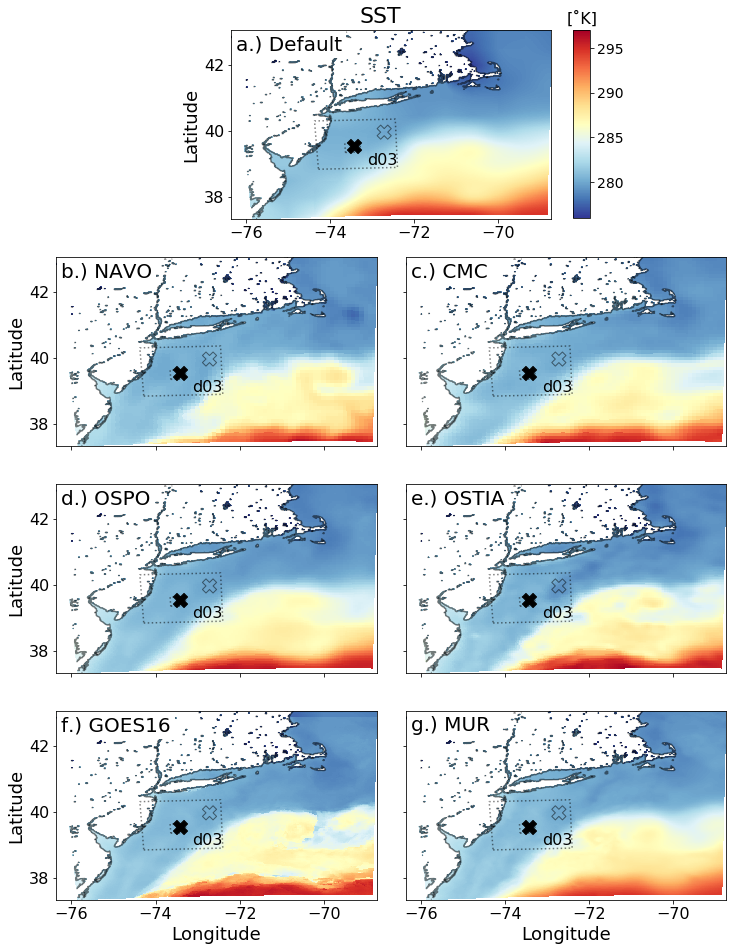

In [12]:
fig = plt.figure(figsize=(12,16))
row = 1
col = 0


pmin,pmax = 276,297
for ss,sst in enumerate(plt_order):

    if sst == 'orig':
        plt_pos = (0,1)
        plt_title = 'Default'
    else:
        plt_pos = (row,col)
        plt_title = sst

    if ss == 0:
        sst_ax = plt.subplot2grid((4,4),plt_pos,colspan=2)
    else:
        sst_ax = plt.subplot2grid((4,4),plt_pos,colspan=2,sharex=sst_ax,sharey=sst_ax)
    
    sst_plt = sst_ax.pcolormesh(wrf_lon,wrf_lat,sst_data[sst],
                                cmap=plt.cm.RdYlBu_r,norm=Normalize(pmin,pmax),
                                rasterized=True)
    sst_ax.contour(wrf_lon,wrf_lat,wrf_landmask,levels=[0.5],colors='k',alpha=0.5)

    #sst_ax.set_title(plt_title,size=18)
    sst_ax.tick_params(labelsize=16)
    
    #sst_ax.text(0.02,0.98,'a.) {}'.format(plt_title), 
    #           transform=sst_ax.transAxes,ha='left',va='top',size=16)
    sst_ax.text(0.015,0.972,'{}.) {}'.format(ascii_lowercase[ss],plt_title),size=20,
                 transform=sst_ax.transAxes,ha='left',va='top',bbox={'fc':'w','ec':'none'})
    if col == 2:
        sst_ax.tick_params(labelleft=False)
    else:
        sst_ax.set_ylabel('Latitude',size=18)

    if ((sst != 'orig') and (row < 3)):
        sst_ax.tick_params(labelbottom=False)
        
    if row == 3:
        sst_ax.set_xlabel('Longitude',size=18)
    if sst != 'orig':
        col += 2
        if col > 3:
            col = 0
            row += 1

    for tt,twr in enumerate(twr_names):
        alpha = 1.0
        fc = 'k'
        if twr == 'E05':
            fc = 'none'
            alpha = 0.5
        sst_ax.scatter(twr_lon[tt],twr_lat[tt],ec='k',
                       s=200,marker='X',
                       label=twr,
                       alpha=alpha,
                       color=fc)

    for dom in [3,4,5]:
        dom_lon = wrfin_dict['d0{}'.format(dom)].XLONG
        dom_lat = wrfin_dict['d0{}'.format(dom)].XLAT

        dom_x = [dom_lon[0,0],
                dom_lon[0,-1],
                dom_lon[-1,-1],
                dom_lon[-1,0],
                dom_lon[0,0]]
        dom_y = [dom_lat[0,0],
                dom_lat[0,-1],
                dom_lat[-1,-1],
                dom_lat[-1,0],
                dom_lat[0,0]]
        
        sst_ax.plot(dom_x,dom_y,c='k',alpha=0.5,ls=':')
        if dom == 3:
            sst_ax.text(dom_lon[0,-1],dom_lat[0,-1],'d03',ha='right',va='bottom',size=16)

cax  = fig.add_axes([0.723,0.717,0.02,0.163])
cbar = plt.colorbar(sst_plt,cax=cax)
cbar.ax.tick_params(labelsize=14)
cbar.ax.set_title('[˚K]',size=16)
plt.suptitle('SST',size=22,y=0.9)
fig_name = '{}SSTDatasets'.format(save_dir)
if save_figs: 
    for save_type in ['.png','.pdf']: plt.savefig(fig_name+save_type,bbox_inches='tight')
plt.show()

# Merge obs and WRF:

In [13]:
HAVE_TO_RERUN = False

interp_data = True
resample_time = '10min'

# Ignore ATS for now:
#lidar_ds = xr.merge([atlshrs_obs,nyserda_obs])
lidar_ds = nyserda_obs.copy()

if resample_time is not None:
    lidar_ds = lidar_ds.resample({'datetime':resample_time}).mean()

lidar_ds['datetime'] = lidar_ds.datetime - pd.Timedelta(obs_shift)

lidar_ds = lidar_ds.sel(datetime=slice(case_start,case_end))
have_seconds = False
for dd in lidar_ds.datetime.data:
    if pd.to_datetime(dd).second != 0: have_seconds = True
if have_seconds: 
    time_str = 's'
    time_fact = 1.0
else:
    time_str = 'min'
    time_fact = 60.0
lidar_obs_dt = pd.to_timedelta(np.min(lidar_ds.datetime.data[1:] - lidar_ds.datetime.data[:-1]))
lidar_obs_dt_str = '{}{}'.format(int(lidar_obs_dt.total_seconds()/time_fact),time_str)
lidar_ds['t2'] = lidar_ds.T
if 'ATS' in lidar_ds.lidar.data:
    lidar_ds = lidar_ds.drop(['T','relh'])
else:
    lidar_ds = lidar_ds.drop(['T'])
lidar_ds = lidar_ds.rename({'sst':'tsk','lidar':'station','Ulevels':'level'}).expand_dims(dim='case')
lidar_ds = lidar_ds.sel(station='E06').drop(['station'])


for cc,case in enumerate(cases[:]):
    if interp_data:
        case_ds_fname = '{}extracted_data/{}_interpolated_extracted_data.nc'.format(main_directory,case)
        #case_ds_fname = '{}extracted_data/{}_interpolated_extracted_data_largeSubsection.nc'.format(main_directory,case)
        
        case_ds = xr.open_dataset(case_ds_fname)
    else:
        case_ds_fname = '{}extracted_data/{}_extracted_data.nc'.format(main_directory,case)
        case_ds = xr.open_dataset(case_ds_fname)
        case_ds = case_ds.assign_coords({'level':case_ds.zs.mean(dim=['datetime','dom'])}).rename({'bottom_top':'level'})
        case_ds = case_ds.interp(coords={'level':lidar_ds.level},method='linear')
        
    case_ds = case_ds.sel(datetime=slice(pd.to_datetime(case_start),
                                         pd.to_datetime(case_end)))
    for dd,dom in enumerate([1,2,3,4,5]):
        dom_ds = case_ds.sel(dom=dom)
        dom_str = 'd0{}'.format(dom)
        case_str = '{}_{}'.format(case,dom_str)
        if HAVE_TO_RERUN:
            if dom <= 3:
                dom_ds = dom_ds.dropna(dim='datetime',how='any')
                dom_ds = dom_ds.interp(coords={'datetime':lidar_ds.datetime},method='linear')

        dom_ds = dom_ds.expand_dims({'case':[case_str]},axis=0)
        dom_ds = dom_ds.drop(['dom'])
        if dd == 0:
            case_ds_int = dom_ds.copy()
        else:
            case_ds_int = xr.merge([case_ds_int,dom_ds])            
            
    #case_ds = case_ds.expand_dims({'case':[case]},axis=0)
    if cc == 0:
        wrf_ds = case_ds_int.copy()
    else:
        wrf_ds = xr.merge([wrf_ds,case_ds_int])
        
wrf_ds_full = wrf_ds.copy()
wrf_ds = wrf_ds.rename({'TSK':'tsk','T2':'t2','wa':'w'})
wrf_ds = wrf_ds[list(lidar_ds.data_vars)]

lidar_ds_full = xr.merge([lidar_ds,wrf_ds])

/glade/u/home/hawbecke/local/envs/mmc/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


# Calculate some metrics:

In [14]:
def is_odd(num):
    return(num % 2 != 0)

def calc_slice_heights(n_slices=5,
                       D=100,
                       H=80):
    if not (is_odd(n_slices)): raise ValueError('n_slices must be odd')
        
    heights = np.zeros(n_slices)
    
    for i in range(1,n_slices + 1):
        heights[i-1] = H + (1.0/float(n_slices))*(i-np.ceil(n_slices/2))*D
    return(np.asarray(heights))
    

def calc_partial_area(D=100,
                      heights=None,
                      show_plot=True):
    
    if heights is None: raise ValueError('Calculate heights first')
        
    n_slices = len(heights)
    h = np.mean(heights[1:] - heights[:-1])
    R = D/2.0
    A = (np.pi*R**2)
    half_ind = int((n_slices+1)/2) # middle slice index
    slice_area = np.zeros(n_slices)
    
    H = heights[half_ind-1] # hub height

    if show_plot:
        fig,ax = plt.subplots(figsize=(5,5))
        ax.set_aspect('equal')
        theta = np.linspace( 0 , 2 * np.pi , 720 )
        radius = R
        a = radius * np.cos( theta )
        b = radius * np.sin( theta ) + H
        plt.plot( a, b ,c='k')

    
    for n in range(0,half_ind):
        h_n = h*(n+1)

        if show_plot:
            if is_odd(n+1):
                fill_color = 'b'
            else:
                fill_color = 'grey'
        area_h_full = (R**2)*np.arccos((R-h_n)/R) - (R-h_n)*np.sqrt(2*R*h_n - h_n**2)
        if n == 0:
            slice_area[n] = area_h_full
            slice_area[n_slices-1] = slice_area[n]
            if show_plot:
                line_bottom = (H-(R-h_n))
                line_top = (H+(R-h_n))
                plt.fill_between(a[np.where(b<=line_bottom)],
                                 b[np.where(b<=line_bottom)],
                                 line_bottom,ec=None,fc=fill_color,alpha=0.2)
                plt.fill_between(a[np.where(b>=line_top)],
                                 b[np.where(b>=line_top)],
                                 line_top,ec=None,fc=fill_color,alpha=0.2)
        elif n == half_ind -1:
            slice_area[n] = A - 2.0*(np.sum(slice_area[:half_ind-1]))
            if show_plot:
                h_n_0 = h*(n)
                line_bottom_B = (H-(R-h_n_0))
                line_top_B = (H-(R-h_n))
                plt_conds = np.where((b>=line_bottom_B) & (b<=line_top_B)) 
                plt.fill_between(a[plt_conds],b[plt_conds],line_top_B,
                                 ec=None,fc=fill_color,alpha=0.2)
        else:
            slice_area[n] = area_h_full - sum(slice_area[:n])
            slice_area[len(heights) - n - 1] = area_h_full - sum(slice_area[:n])
            if show_plot:
                h_n_0 = h*(n)
                line_bottom_B = (H-(R-h_n_0))
                line_top_B = (H-(R-h_n))
                plt_conds = np.where((b>=line_bottom_B) & (b<=line_top_B)) 
                plt.fill_between(a[plt_conds],b[plt_conds],line_top_B,
                                 ec=None,fc=fill_color,alpha=0.2)
                
                line_top_T = (H+(R-h_n_0))
                line_bottom_T = (H+(R-h_n))
                plt_conds = np.where((b>=line_bottom_T) & (b<=line_top_T)) 
                plt.fill_between(a[plt_conds],b[plt_conds],line_bottom_T,
                                 ec=None,fc=fill_color,alpha=0.2)

    if show_plot:
        for kk,z in enumerate(heights):
            plt.text(0.0,z,'{0:4.2f}%'.format(100.0*(slice_area[kk]/A)),
                     ha='center',va='center')
        plt.ylabel('Height')
        plt.xlabel('Distance')
        plt.title('Area of Each Segment')
        plt.show()
    return(np.asarray(slice_area))
    
def interpolate_var_to_Heights(var,var_z,heights):
    var_interp = np.interp(heights,var_z,var)
    return(var_interp)

def RotorEquivalentWindSpeed(rotor_diameter=100, # rotor Diameter 
                             hub_height=80,  # rotor height
                             n_slices=5, # Number of slices to use
                             U_profile=None,   # U (same size as n_slices)
                             U_heights=None, # Heights of U
                             show_plot=False,
                             include_veer=False,
                             dir_profile=None,
                            ):
    
    heights = calc_slice_heights(n_slices=n_slices,D=rotor_diameter,H=hub_height)

    U_interp = interpolate_var_to_Heights(U_profile,U_heights,heights)
    if include_veer:
        if dir_profile is not None:
            dir_interp = interpolate_var_to_Heights(dir_profile,U_heights,heights)
        else:
            raise ValueError('dir_profile needs to be specified to include veer')

    if show_plot:
        plt.plot(U_profile,U_heights,c='k',marker='x',label='Orig')
        plt.plot(U_interp,heights,c='g',marker='o',label='interp')
        plt.legend(frameon=False)
        plt.ylabel('Height')
        plt.xlabel('Wind speed')
        plt.show()
        if include_veer:
            plt.plot(dir_profile,U_heights,c='k',marker='x',label='Orig')
            plt.plot(dir_interp,heights,c='g',marker='o',label='interp')
            plt.legend(frameon=False)
            plt.ylabel('Height')
            plt.xlabel('Wind speed')
            plt.show()
        
    partial_areas = calc_partial_area(D=rotor_diameter,heights=heights,show_plot=show_plot)
    
    R = rotor_diameter/2.0
    A = (np.pi*R**2)
    Ai_over_A = partial_areas/A
    
    if include_veer:
        #rews = np.sum(Ai_over_A*(np.asarray(U_interp)**3.0))**(1/3.0)
        hub_dir = dir_interp[np.where(heights==hub_height)]
        dir_diff = np.deg2rad(dir_interp - hub_dir)
        rews = np.sum(Ai_over_A*np.abs(U_interp)*np.cos(dir_diff))
    else:
        #rews = np.sum(Ai_over_A*(np.asarray(U_interp)**3.0))**(1/3.0)
        rews = np.sum(Ai_over_A*(np.abs(U_interp)))

    return(rews)
    

In [15]:
rotor_rad = rotor_D/2

low_z = hub_height - rotor_rad
up_z = hub_height + rotor_rad

shear = (lidar_ds_full.wspd.sel(level=up_z) - lidar_ds_full.wspd.sel(level=low_z))/(up_z-low_z)
shear.name = 'rotor_shear'
lidar_ds_full['rotor_shear'] = shear

delT = lidar_ds_full.t2 - lidar_ds_full.tsk
delT.name = 'delT'
lidar_ds_full['delT'] = delT

max_wspd = lidar_ds_full.wspd.max(dim='level')
max_wspd.name = 'max_wspd'
lidar_ds_full['max_wspd'] = max_wspd

hub_wspd = lidar_ds_full.wspd.sel(level=hub_height)
hub_wspd.name = 'hub_wspd'
lidar_ds_full['hub_wspd'] = hub_wspd

low_shear = (lidar_ds_full.wspd.sel(level=hub_height) - lidar_ds_full.wspd.sel(level=low_z))/rotor_rad
low_shear.name = 'low_shear'
lidar_ds_full['low_shear'] = low_shear

# Not sure if there's a better way than looping... but loop to find LLJ height:
stations_of_interest = ['E06']
llj_height = np.zeros(np.shape(lidar_ds_full.t2))
rews = np.zeros(np.shape(lidar_ds_full.t2))
for tt,time in enumerate(lidar_ds_full.datetime):
    wind_profile = lidar_ds_full.sel(datetime=time).wspd
    for cc,case in enumerate(lidar_ds_full.case.data):
        wind_profile = lidar_ds_full.sel(datetime=time,case=case).wspd
        height_profile = lidar_ds_full.sel(datetime=time,case=case).level
        dir_profile = lidar_ds_full.sel(datetime=time,case=case).wdir

        if np.isnan(wind_profile.max().data):
            llj_height[cc,tt] = np.nan
        else:
            llj_height[cc,tt] = height_profile[np.where(wind_profile==wind_profile.max())].data[0]
            rews[cc,tt] = RotorEquivalentWindSpeed(rotor_diameter=rotor_D, 
                                                   hub_height=hub_height, 
                                                   n_slices=7, 
                                                   U_profile=wind_profile, 
                                                   U_heights=height_profile, 
                                                   show_plot=False,
                                                   include_veer=True,
                                                   dir_profile=dir_profile)
llj_height_da = xr.DataArray(
                            data=llj_height,
                            dims=['case', 'datetime'],#, 'station'],
                            coords=dict(
                                case=lidar_ds_full.case.data,
                                #station=lidar_ds_full.station.sel(station=stations_of_interest).data,
                                datetime=lidar_ds_full.datetime.data,
                            ),
                        )
lidar_ds_full['llj_height'] = llj_height_da

rews_da = xr.DataArray(
                       data=rews,
                       dims=['case', 'datetime'],#, 'station'],
                       coords=dict(
                           case=lidar_ds_full.case.data,
                           #station=lidar_ds_full.station.sel(station=stations_of_interest).data,
                           datetime=lidar_ds_full.datetime.data,
                       ),
                   )
lidar_ds_full['rews'] = rews_da

# Visualize model output:

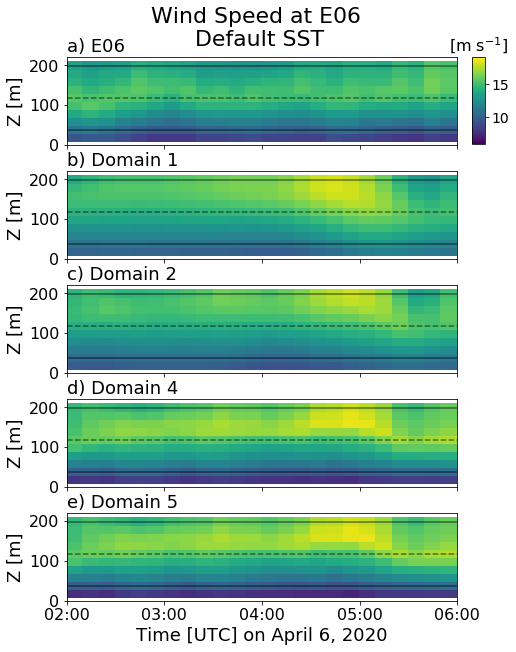

In [16]:
xticks = pd.date_range(start=pd.to_datetime(case_start),
                       end=pd.to_datetime(case_end),
                       freq=pd.Timedelta('1h'))
xticklabels = []
for xtick in xticks: xticklabels += [str(xtick)[-8:-3]]

for cc,case in enumerate(cases[:1]):
    doms_to_plot = [1,2,4,5]
    
    nrows = len(doms_to_plot) + 1
    fig,ax = plt.subplots(nrows=nrows,figsize=(7,10),sharex=True)
    plt.subplots_adjust(hspace=0.3)
    
    cases_to_sel = []
    for case_str in lidar_ds_full.case:
        case_str = str(case_str.data)
        if case in case_str:
            if int(case_str.split('_')[-1][-1]) in doms_to_plot:
                cases_to_sel += [case_str]

    #vmin = lidar_ds_full.sel(case=cases_to_sel).wspd.min()
    #vmax = lidar_ds_full.sel(case=cases_to_sel).wspd.max()
    
    vmin = uniform_wspd_min
    vmax = uniform_wspd_max
    
    obs_ds = lidar_ds_full.sel(case='obs')
    obs_plt = ax[0].pcolormesh(obs_ds.datetime,plt_levels,obs_ds.wspd.T,
                               vmin=vmin,vmax=vmax,rasterized=True)
    ax[0].set_title('{}) E06'.format(ascii_lowercase[0]),size=18,x=0.0,ha='left')
    for dd,dom in enumerate(doms_to_plot):
        dom_str = 'd0{}'.format(dom)
        dom_ds = lidar_ds_full.sel(case='{}_{}'.format(case,dom_str))
        #twr_plt = ax[dd+1].pcolormesh(dom_ds.datetime,dom_ds.level,dom_ds.wspd.T,
        #                              vmin=vmin,vmax=vmax,rasterized=True)
        twr_plt = ax[dd+1].pcolormesh(dom_ds.datetime,plt_levels,dom_ds.wspd.T,
                                      vmin=vmin,vmax=vmax,rasterized=True)
        ax[dd+1].set_title('{}) Domain {}'.format(ascii_lowercase[dd+1],dom),size=18,x=0.0,ha='left')

    for dd in range(0,nrows):
        ax[dd].tick_params(labelsize=16)
        #ax[dd].set_title(dom_str,size=22)
        ax[dd].set_ylabel('Z [m]',size=18)
        ax[dd].set_xticks(xticks)
        ax[dd].set_xticklabels(xticklabels)
        ax[dd].set_yticks(np.arange(0,201,100))
        ax[dd].set_ylim(0,220)
        ax[dd].plot([pd.to_datetime(case_start),pd.to_datetime(case_end)],
                    [low_z,low_z],c='k',alpha=0.5)
        ax[dd].plot([pd.to_datetime(case_start),pd.to_datetime(case_end)],
                    [hub_height,hub_height],c='k',alpha=0.5,ls='--')
        ax[dd].plot([pd.to_datetime(case_start),pd.to_datetime(case_end)],
                    [up_z,up_z],c='k',alpha=0.5)
    ax[nrows-1].set_xlabel('Time [UTC] on April 6, 2020',size=18)
    cax  = fig.add_axes([0.93,0.76,0.025,0.12])

    cbar = plt.colorbar(twr_plt,cax=cax)
    cbar.ax.tick_params(labelsize=14)
    cbar.ax.set_title('[m s$^{-1}$]',size=16)
    if cc == 0:
        case_str = 'Default'
    else:
        case_str = case_dict[case]['sst']
    plt.suptitle('Wind Speed at E06\n {} SST'.format(case_str),size=22,y=0.95)
    plt.draw()
    xticklabels = ax[nrows-1].get_xticklabels()
    #new_xlabels = []
    #for lbl in xticklabels:
    #    new_xlabels += ['{}'.format(lbl.get_text()[-2:])]
    #ax[nrows-1].set_xticklabels(new_xlabels, rotation = 0, ha="center")
    
    fig_name = '{}DomainCompare_{}'.format(save_dir,case_str)
    if save_figs: 
        for save_type in ['.png','.pdf']: plt.savefig(fig_name+save_type,bbox_inches='tight')
    
    plt.show()

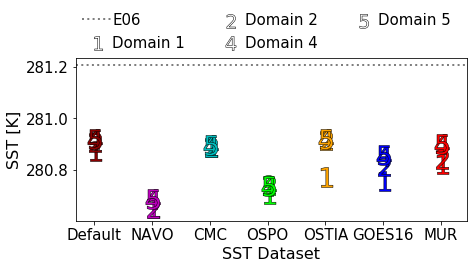

In [17]:
plt.figure(figsize=(7,3))
varn = 'tsk'
xlabels = []
for cc,case in enumerate(case_plot_order):
    cases_of_interest_case = []
    for dom in [1,2,4,5]:
        dom_str = 'd0{}'.format(dom)
        case_str = '{}_{}'.format(case,dom_str)


        dom_ds = lidar_ds_full.sel(case=case_str)
        #plt.scatter(lidar_ds_full.sel(case='obs')[varn],dom_ds[varn])
        plt.scatter(cc,dom_ds[varn].mean(dim='datetime'),
                    c=case_dict[case]['color'],
                    marker=dom_dict[dom]['marker'],
                    ec='k',
                    lw=0.5,
                    s=400)
        if cc == 0:
            plt.scatter([],[],c='w',ec='k',lw=0.5,s=200,marker=dom_dict[dom]['marker'],label='Domain {}'.format(dom))
    case_title = case_dict[case]['sst']
    if case_title == 'orig': case_title = 'Default'
    xlabels += [case_title]
    
plt.xticks(np.arange(0,len(cases)),xlabels)
plt.axhline(lidar_ds_full.sel(case='obs')[varn].mean(dim='datetime'),
            c='k',alpha=0.5,ls=':',lw=2.0,label='E06')
plt.tick_params(labelsize=15)
plt.ylabel('SST [K]',size=16)
plt.xlabel('SST Dataset',size=16)
plt.legend(frameon=False,fontsize=15,ncol=3,loc=(0.0,1.01),
           handletextpad=0.01)
fig_name = '{}SSTCompare'.format(save_dir)
if save_figs: 
    for save_type in ['.png','.pdf']: plt.savefig(fig_name+save_type,bbox_inches='tight')

plt.show()


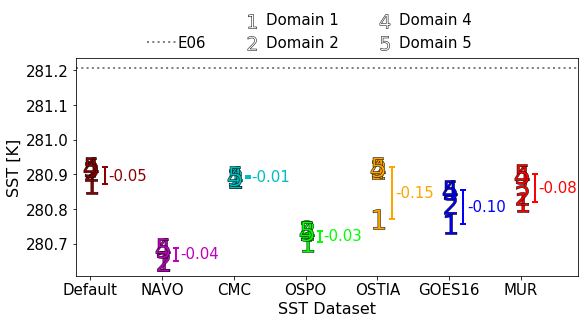

In [18]:
fig,ax = plt.subplots(figsize=(9,4))
varn = 'tsk'
xlabels = []

for cc,case in enumerate(case_plot_order):
    cases_of_interest_case = []
    for dom in [1,2,4,5]:
        dom_str = 'd0{}'.format(dom)
        case_str = '{}_{}'.format(case,dom_str)


        dom_ds = lidar_ds_full.sel(case=case_str)
        #plt.scatter(lidar_ds_full.sel(case='obs')[varn],dom_ds[varn])
        plt.scatter(cc,dom_ds[varn].mean(dim='datetime'),
                    c=case_dict[case]['color'],
                    marker=dom_dict[dom]['marker'],
                    ec='k',
                    lw=0.5,
                    s=400)
        if cc == 0:
            plt.scatter([],[],c='w',ec='k',lw=0.5,s=200,marker=dom_dict[dom]['marker'],label='Domain {}'.format(dom))
            if dom == 1: plt.plot([],[],c='w',label=' ')    

            
    d01_val = lidar_ds_full.sel(case='{}_{}'.format(case,'d01'))[varn].mean(dim='datetime')
    d05_val = lidar_ds_full.sel(case='{}_{}'.format(case,'d05'))[varn].mean(dim='datetime')
    diff_val = d01_val - d05_val
    
    sep = 0.2
    plt.plot([cc+sep,cc+sep],[d01_val,d05_val],
             c=case_dict[case]['color'],lw=2.0)
    plt.scatter(cc+sep,d01_val,marker='_',
                c=case_dict[case]['color'],lw=2.0)
    plt.scatter(cc+sep,d05_val,marker='_',
                c=case_dict[case]['color'],lw=2.0)
    text_loc_x = cc+sep+0.05
    text_loc_y = d01_val-diff_val/2
        
    ax.text(text_loc_x,text_loc_y,'{0:3.2f}'.format(float(diff_val.data)),
            fontsize=15,va='center',c=case_dict[case]['color'])

    case_title = case_dict[case]['sst']
    if case_title == 'orig': case_title = 'Default'
    xlabels += [case_title]

plt.xticks(np.arange(0,len(cases)),xlabels)
plt.axhline(lidar_ds_full.sel(case='obs')[varn].mean(dim='datetime'),
            c='k',alpha=0.5,ls=':',lw=2.0,label='E06')

plt.tick_params(labelsize=15)
plt.ylabel('SST [K]',size=16)
plt.xlabel('SST Dataset',size=16)
plt.legend(frameon=False,fontsize=15,ncol=3,loc=(0.13,1.01),
           handletextpad=0.01)
plt.xlim(-0.2,cc+0.8)
fig_name = '{}SSTCompareRanges'.format(save_dir)
if save_figs: 
    for save_type in ['.png','.pdf']: plt.savefig(fig_name+save_type,bbox_inches='tight')

plt.show()

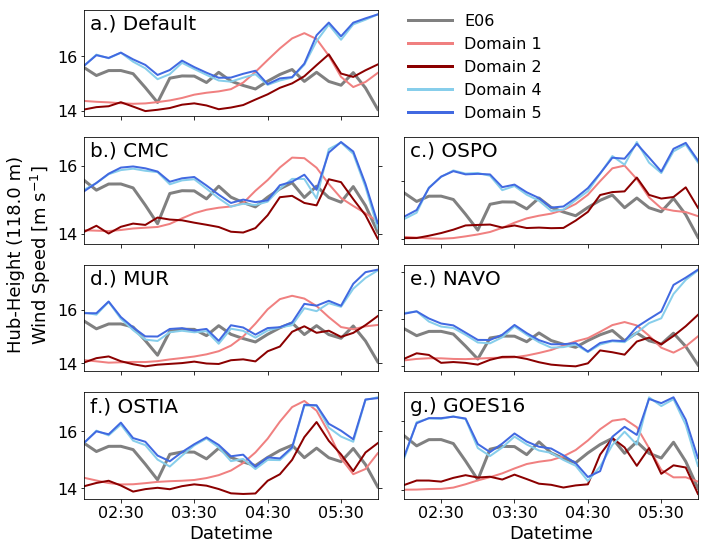

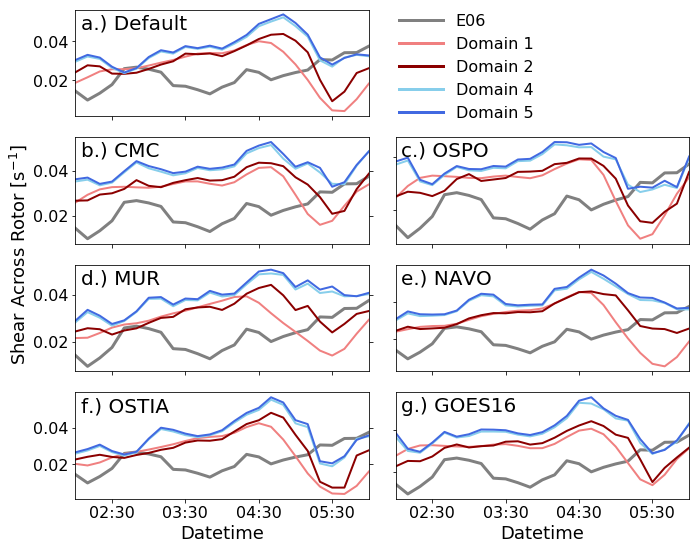

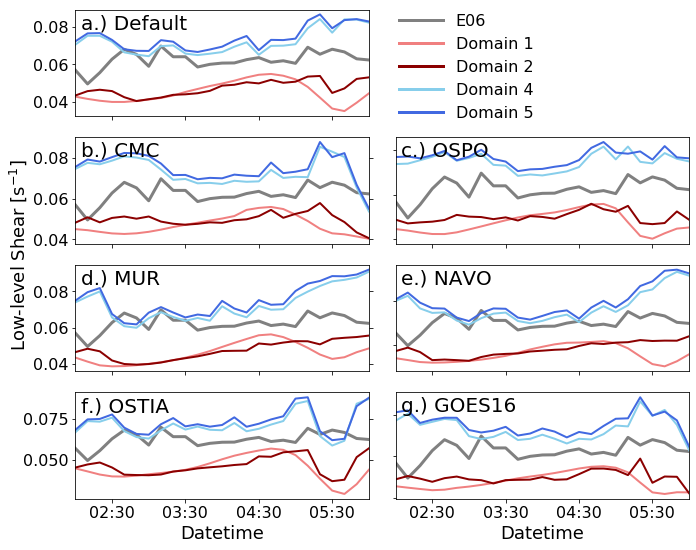

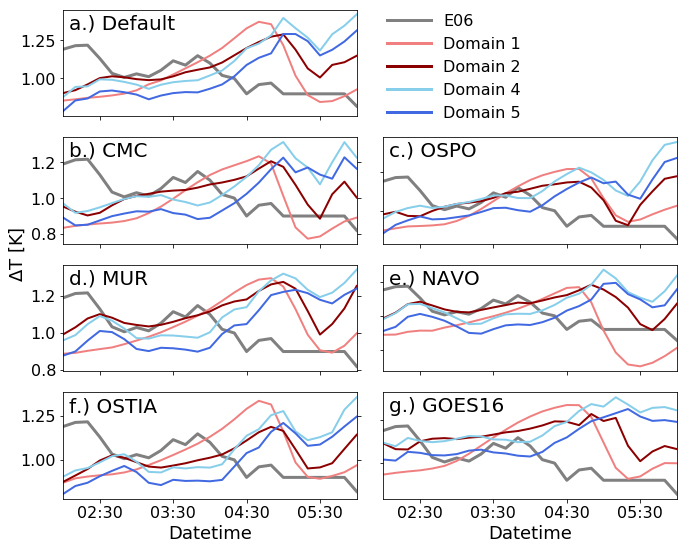

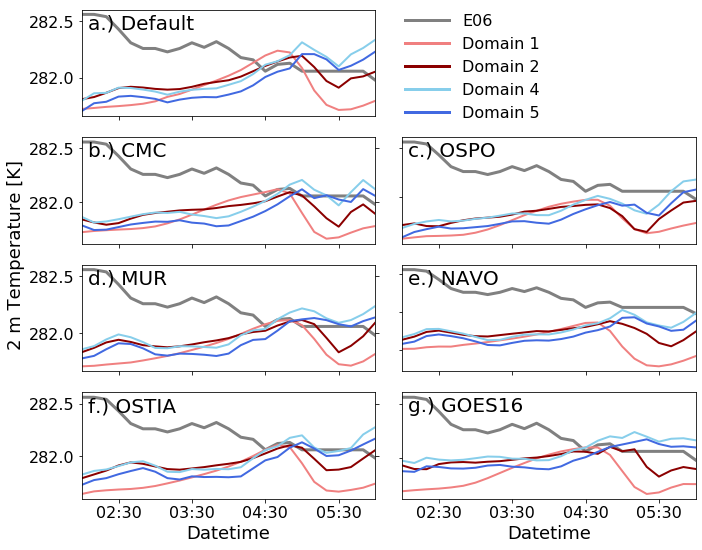

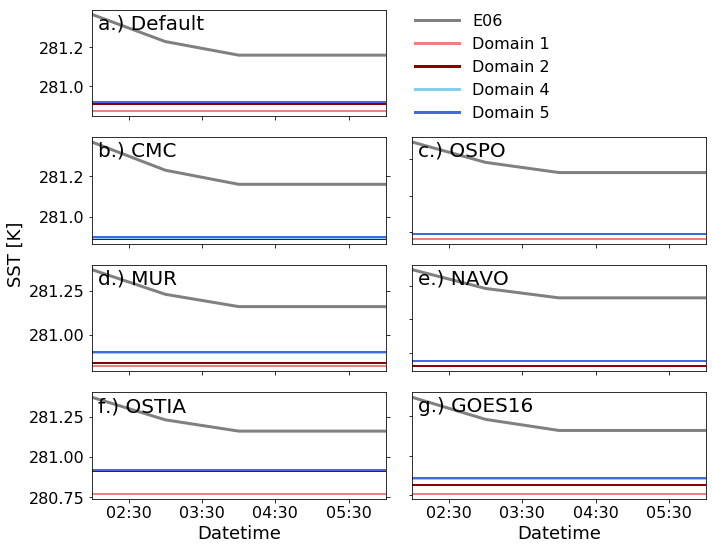

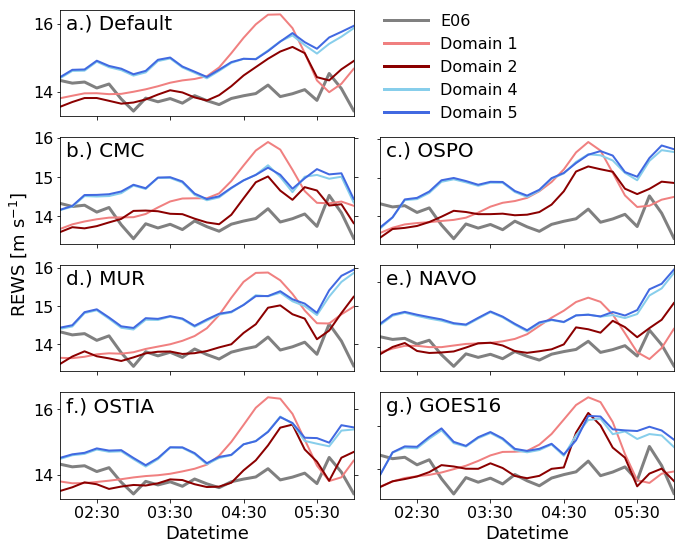

In [19]:
doms_to_plot = [1,2,4,5]

var_plot_dict = {'wspd':{'ylabel':'Hub-Height ({0:3.1f} m)\nWind Speed '.format(hub_height) + '[m s$^{-1}$]',
                         'title':'Hub-Height Wind Speed ({0:3.1f} m)'.format(hub_height)},
          'rotor_shear':{'ylabel':'Shear Across Rotor [s$^{-1}$]',
                         'title':'Shear Across Rotor'},
            'low_shear':{'ylabel':'Low-level Shear [s$^{-1}$]',
                         'title':'Low-level Shear'},
                 'delT':{'ylabel':'$\Delta$T [K]',
                         'title':'$\Delta$T [K]'},
                   't2':{'ylabel':'2 m Temperature [K]',
                         'title':'2 m Temperature [K]'},
                  'tsk':{'ylabel':'SST [K]',
                         'title':'SST [K]'},
                 'rews':{'ylabel':'REWS [m s$^{-1}$]',
                         'title':'REWS'},
                }
vars_to_plot = list(var_plot_dict.keys())

#hub_height = 98.0 # 98.0 or 118.0

show_shear = False 

xticks = pd.date_range(start=pd.to_datetime(case_start)+pd.to_timedelta(30,'min'),
                       end=pd.to_datetime(case_end)-pd.to_timedelta(30,'min'),
                       freq=pd.Timedelta('1h'))
xticklabels = []
for xtick in xticks: xticklabels += [str(xtick)[-8:-3]]


for varn in vars_to_plot:

    row,col = 0,0

    fig = plt.figure(figsize=(11,9))
    plt.subplots_adjust(wspace=0.2,hspace=0.2)
    for cc,case in enumerate(cases):
        plt_pos = (row,col)
        if cc == 0:
            plt_ax = plt.subplot2grid((4,4),plt_pos,colspan=2)
            plt_title = 'Default'
        else:
            plt_title = case_dict[case]['sst']
            plt_pos = (row,col)
            plt_ax = plt.subplot2grid((4,4),plt_pos,colspan=2,sharex=plt_ax)#,sharey=plt_ax)

        obs_ds = lidar_ds_full.sel(case='obs').sel(datetime=slice(case_start,case_end))
        obs_var = obs_ds[varn]
        if 'level' in obs_var.dims:
            obs_var = obs_var.sel(level=hub_height)
        obs_plt = obs_var.plot(ax=plt_ax,c='grey',lw=3.0,label='Obs')
        for dom in doms_to_plot:
            dom_str = 'd0{}'.format(dom)
            dom_ds = lidar_ds_full.sel(case='{}_{}'.format(case,dom_str)).sel(datetime=slice(case_start,case_end))
            plt_var = dom_ds[varn]
            if 'level' in plt_var.dims:
                plt_var = plt_var.sel(level=hub_height)
            
            plt_var.plot(ax=plt_ax,
                         #c=case_dict[case]['color'],
                         c=dom_dict[dom]['color'],
                         #ls=dom_dict[dom]['ls'],
                         ls='-',
                         lw=2.0,
                         #label='Domain {}'.format(dom)
                         )

        plt_ax.set_title('')
        plt_ax.set_xlim(pd.to_datetime(case_start),pd.to_datetime(case_end))
        plt_ax.tick_params(labelsize=16)
        plt_ax.text(0.02,0.96,'{}.) {}'.format(ascii_lowercase[cc],plt_title),size=20,
                     transform=plt_ax.transAxes,ha='left',va='top')
        plt_ax.set_xticks(xticks)
        plt_ax.set_xticklabels(xticklabels,rotation=0,ha='center')
        if cc == 0:
            leg_handles = plt.plot([], [], c='grey', 
                                   ls='-',
                                   lw=3.0,
                                   label='E06')
            for dom in doms_to_plot:
                leg_handles += plt.plot([], [], c=dom_dict[dom]['color'], 
                                        ls='-',
                                        lw=3.0,
                                        label='Domain {}'.format(dom))


            plt_ax.legend(handles=leg_handles,
                          handlelength=2.75,
                          frameon=False,
                          fontsize=16,
                          loc=(1.08,-0.1))
        if col == 2:
            plt_ax.tick_params(labelleft=False)
            plt_ax.set_ylabel('',size=18)
        else:
            if (col == 0):
                if (row > 0):
                    plt_ax.tick_params(right=True)
            if row == 2:
                plt_ax.set_ylabel(var_plot_dict[varn]['ylabel'],size=18,y=1.1)
            else:
                plt_ax.set_ylabel('',size=18)

        if row < 3:
            plt_ax.tick_params(labelbottom=False)

        if row == 3:
            plt_ax.set_xlabel('Datetime',size=18)
        else:
            plt_ax.set_xlabel('',size=18)

        if cc == 0:
            col += 3
        else:
            col += 2
        if col >= 3:
            col = 0
            row += 1

        if show_shear:
            tax = plt_ax.twinx()


    #plt.suptitle(var_plot_dict[varn]['title'],size=22,y=0.93)
    fig_name = '{}timeseries_{}_new'.format(save_dir,varn)

    if save_figs: 
        for save_type in ['.png','.pdf']: plt.savefig(fig_name+save_type,bbox_inches='tight')
    plt.show()

# Calculate Ensemble Statistics:

In [20]:
def ensemble_statistics(ds,
                        variables=None,
                        observation_key='obs',
                        members_dim=None,
                        members=None,
                        ):

    if members_dim is None:
        raise ValueError ('Must specify dimension that defines the members (members_dim)')
    else:
        if members is None:
            members = list(ds[members_dim].data)
            members.remove(observation_key)
        
    if variables is None:
        variables = list(ds.variables)
        for coord in list(ds.coords):
            variables.remove(coord)

    new_ds = ds.copy()
    for varn in variables:
        data = ds[varn].sel({members_dim:members})
        ens_mean = data.mean(dim=members_dim)
        ens_mean_str = 'ens_mean_{}'.format(varn)
        ens_mean.name = ens_mean_str
        new_ds[ens_mean_str] = ens_mean
        
        ens_spread = (((data - ens_mean)**2).mean(dim=members_dim))**0.5
        ens_spread_str = 'ens_spread_{}'.format(varn)
        ens_spread.name = ens_spread_str
        new_ds[ens_spread_str] = ens_spread
        
        ens_error = ((ds[varn].sel({members_dim:observation_key}) - ens_mean)**2)**0.5
        ens_error_str = 'ens_error_{}'.format(varn)
        ens_error.name = ens_error_str
        new_ds[ens_error_str] = ens_error
        
    return(new_ds)


In [21]:
cases_of_interest = ['obs']
for cc,case in enumerate(cases):
    for dom in [1,2,3,4,5]:
        dom_str = 'd0{}'.format(dom)
        cases_of_interest += [case+'_'+dom_str]

#cases_of_interest = lidar_ds_full.case.data

ens_ds = lidar_ds_full.sel(case=cases_of_interest).copy()
ens_ds_avg = ens_ds.mean(dim='datetime')

ens_dict = {}
ens_dict_avg = {}
#for dom in doms_of_interest:
for dom in [1,2,3,4,5]:
    dom_str = 'd0{}'.format(dom)
    cases_of_interest_dom = []
    for cc,case in enumerate(cases_of_interest):
        if dom_str in case:
            cases_of_interest_dom += [case]

    ens_ds_dom = ens_ds.sel(case=cases_of_interest_dom + ['obs'])
    ens_dict[dom_str] = ensemble_statistics(ens_ds_dom,
                                            members_dim='case')
    
    ens_ds_avg_dom = ens_ds_avg.sel(case=cases_of_interest_dom + ['obs'])
    ens_dict_avg[dom_str] = ensemble_statistics(ens_ds_avg_dom,
                                                members_dim='case')

In [22]:
class AnyObjectHandler(HandlerBase):
    def create_artists(self, legend, orig_handle,
                       x0, y0, width, height, fontsize, trans):
        l1 = plt.Line2D([x0,y0+width], [0.7*height,0.7*height],
                           color=orig_handle[0])
        l2 = plt.Line2D([x0,y0+width], [0.3*height,0.3*height], 
                           color=orig_handle[1])
        return [l1, l2]


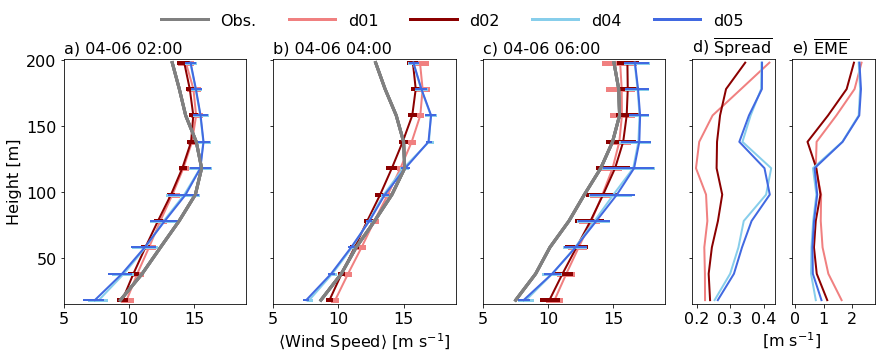

In [23]:
# Pick the time period of interest and average statistics over this period?
#plt_start = pd.to_datetime(case_start)
plt_start = pd.to_datetime(case_start)
plt_end = pd.to_datetime(case_end)

plt_ntimes = 3
ptimes = pd.date_range(plt_start,plt_end,periods=plt_ntimes)

fig = plt.figure(figsize=(12,4))
gs1 = gridspec.GridSpec(1, 8)

gs1.update(left=0.05, right=0.95, wspace=0.3)

ax1 = plt.subplot(gs1[0, 0:2])
ax2 = plt.subplot(gs1[0, 2:4], sharey=ax1)
ax3 = plt.subplot(gs1[0, 4:6], sharey=ax1)
ax4 = plt.subplot(gs1[0, 6], sharey=ax1) 
ax5 = plt.subplot(gs1[0, 7], sharey=ax1)

for axi in [ax2,ax3,ax4,ax5]:
    axi.tick_params(labelleft=False)

gs1.tight_layout(fig)

nbins = len(ax5.get_xticklabels())
ax5.xaxis.set_major_locator(MaxNLocator(nbins=nbins))
ax4.xaxis.set_major_locator(MaxNLocator(nbins=nbins, prune='upper'))

# change axis location of ax5
pos4 = ax4.get_position()
pos5 = ax5.get_position()

points4 = pos4.get_points()
points5 = pos5.get_points()

mid_x = 0.5*(points4[1][0] + points5[0][0])

points4[1][0] = mid_x - 0.01
points5[0][0] = mid_x + 0.01

pos4.set_points(points4)
pos5.set_points(points5)

ax4.set_position(pos4)
ax5.set_position(pos5)

ax = [ax1,ax2,ax3,ax4,ax5]

varn = 'wspd'

for dd,dom in enumerate(doms_of_interest):
#for dd,dom in enumerate([1,2,4,5]):
    
    mean_ls = dom_dict[dom]['ls']
    mean_ls = '-'
    ls = '-'
    
    dom_str = 'd0{}'.format(dom)
    ens_dom_ds = ens_dict[dom_str]
    data_toi = ens_dom_ds.sel(datetime=ptimes)
    data_avg_ds = ens_dom_ds.sel(datetime=slice(case_start,case_end)).mean(dim='datetime')

    cases_of_interest_dom = []
    for cc,case in enumerate(cases_of_interest):
        if dom_str in case:
            cases_of_interest_dom += [case]

    for tt,ptime in enumerate(data_toi.datetime):
        data_varn = data_toi.sel(case=cases_of_interest_dom,datetime=ptime)[varn]
        dom_min = data_varn.min(dim='case')
        dom_max = data_varn.max(dim='case')

        for lvl in data_toi.level:

            ax[tt].plot([dom_min.sel(level=lvl),dom_max.sel(level=lvl)],
                     #[lvl+dd*2,lvl+dd*2],c=dom_dict[dom]['color'],lw=2.0)
                     [lvl,lvl],c=dom_dict[dom]['color'],lw=5-dd)
        #ax[tt].fill_betweenx(dom_min.level,dom_min,dom_max,hatch='-')
        data_toi['ens_mean_{}'.format(varn)].sel(datetime=ptime).plot(y='level',
                                                                      c=dom_dict[dom]['color'],
                                                                      lw=2.0,
                                                                      ax=ax[tt],
                                                                      ls=mean_ls,
                                                                      alpha=1.0)
        data_toi.sel(case='obs',datetime=ptime)[varn].dropna(how='all',dim='level').plot(y='level',
                                                                                         ax=ax[tt],
                                                                                         c='grey',
                                                                                         ls=ls,
                                                                                         lw=3.0)
    if dd == 0:
        err_str  = 'EME'
        sprd_str = 'Spread'
    else:
        err_str = None
        sprd_str = None

    if dom >= 3:
        spr_c = les_spread
        err_c = les_eme
    else:
        spr_c = meso_spread
        err_c = meso_eme
        
    data_avg_ds['ens_error_{}'.format(varn)].dropna(how='all',dim='level').plot(y='level',
                                                                                #c=err_c,
                                                                                c=dom_dict[dom]['color'],
                                                                                ax=ax[-1],
                                                                                label=err_str,
                                                                                #ls=dom_dict[dom]['ls'],
                                                                                ls=mean_ls,
                                                                                lw=2.0)
    data_avg_ds['ens_spread_{}'.format(varn)].plot(y='level',
                                                   #c=spr_c,
                                                   c=dom_dict[dom]['color'],
                                                   ax=ax[-2],
                                                   label=sprd_str,
                                                   #ls=dom_dict[dom]['ls'],
                                                   ls=mean_ls,
                                                   lw=2.0)
    for axi in range(0,plt_ntimes+2):
        ax[axi].tick_params(labelsize=16)
        ax[axi].set_ylabel('')
        ax[axi].set_xlabel('')
        if axi < plt_ntimes:
            title_str = '{}) {}'.format(ascii_lowercase[axi],str(ptimes[axi])[5:-3])
        elif axi == plt_ntimes:
            title_str = '{}) '.format(ascii_lowercase[axi]) + r'$\overline{\mathrm{Spread}}$'
        else:
            title_str = '{}) '.format(ascii_lowercase[axi]) + r'$\overline{\mathrm{EME}}$'
        ax[axi].set_title(title_str,size=16,x=0.0,ha='left')
        #if dd == 0:
        #    ax[axi].fill_between([0,30],low_z,up_z,fc='k',ec='none',alpha=0.1)


    if varn == 'delT':
        var_str = '∆T'
    else:
        var_str = varn.upper()

    if dd == 0:
        ax[0].plot([-10,-11],[1,1],c='grey',ls=ls,label='Obs.',lw=3.0)#,marker='o')
    ax[0].plot([-10,-11],[1,1],
               #c='k',
               c=dom_dict[dom]['color'],
               #ls=dom_dict[dom]['ls'],
               ls=mean_ls,
               label=dom_str,lw=3.0)#,marker='o')

    ax[0].set_ylabel('Height [m]',size=16)
    ax[-1].set_xlim(-0.1,2.8)

var_min,var_max = 5,19

for axi in range(0,plt_ntimes):
    if axi == 1:
        ax[axi].set_xlabel(r'$\langle$Wind Speed$\rangle$ [m s$^{-1}$]',size=16)
    else:
        ax[axi].set_xlabel('')
    ax[axi].set_xlim(var_min,var_max)
ax[-1].set_xlabel('[m s$^{-1}$]',size=16,x=-0.01)
ax[0].set_ylim(15,201)

leg = ax[0].legend(loc=(0.5,1.10),frameon=False,ncol=6,fontsize=16,handlelength=2.9)
#for dd,text in enumerate(leg.get_texts()):
#    if dd == 0:
#        text.set_color('k')
#    else:
#        text.set_color(dom_dict[doms_of_interest[dd-1]]['color'])

fig_name = '{}SpreadError3times_wspd_noMembers_new'.format(save_dir)
if save_figs: 
    for save_type in ['.png','.pdf']: plt.savefig(fig_name+save_type,bbox_inches='tight')
plt.show()

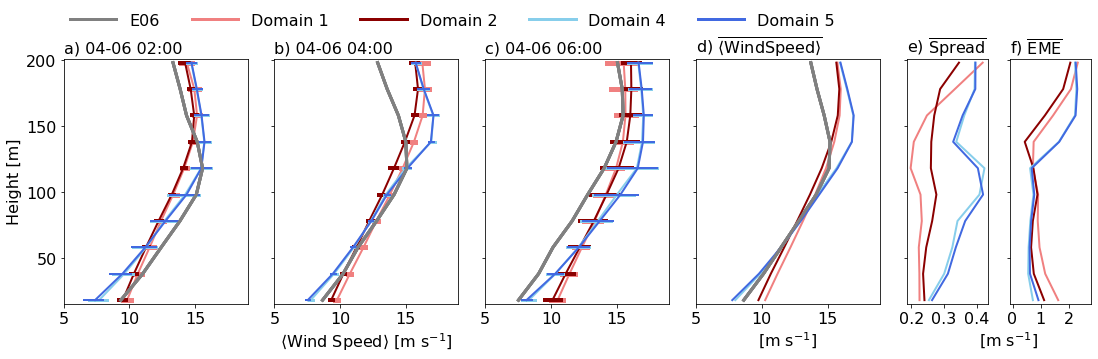

In [28]:
# Pick the time period of interest and average statistics over this period?
#plt_start = pd.to_datetime(case_start)
plt_start = pd.to_datetime(case_start)
plt_end = pd.to_datetime(case_end)

plt_ntimes = 3
ptimes = pd.date_range(plt_start,plt_end,periods=plt_ntimes)

fig = plt.figure(figsize=(15,4))
gs1 = gridspec.GridSpec(1, 10)

gs1.update(left=0.05, right=0.95, wspace=0.3)

ax1 = plt.subplot(gs1[0, 0:2])
ax2 = plt.subplot(gs1[0, 2:4], sharey=ax1)
ax3 = plt.subplot(gs1[0, 4:6], sharey=ax1)
axM = plt.subplot(gs1[0, 6:8], sharey=ax1)
ax4 = plt.subplot(gs1[0, 8], sharey=ax1) 
ax5 = plt.subplot(gs1[0, 9], sharey=ax1)

ax = [ax1,ax2,ax3,axM,ax4,ax5]

for axi in ax[1:]:
    axi.tick_params(labelleft=False)

gs1.tight_layout(fig)

nbins = len(ax5.get_xticklabels())
ax5.xaxis.set_major_locator(MaxNLocator(nbins=nbins))
ax4.xaxis.set_major_locator(MaxNLocator(nbins=nbins, prune='upper'))

# change axis location of ax5
pos4 = ax4.get_position()
pos5 = ax5.get_position()

points4 = pos4.get_points()
points5 = pos5.get_points()

mid_x = 0.5*(points4[1][0] + points5[0][0])

points4[1][0] = mid_x - 0.01
points5[0][0] = mid_x + 0.01

pos4.set_points(points4)
pos5.set_points(points5)

ax4.set_position(pos4)
ax5.set_position(pos5)


varn = 'wspd'

for dd,dom in enumerate(doms_of_interest):
#for dd,dom in enumerate([1,2,4,5]):
    
    mean_ls = dom_dict[dom]['ls']
    mean_ls = '-'
    ls = '-'
    
    dom_str = 'd0{}'.format(dom)
    ens_dom_ds = ens_dict[dom_str]
    data_toi = ens_dom_ds.sel(datetime=ptimes)
    data_avg_ds = ens_dom_ds.sel(datetime=slice(case_start,case_end)).mean(dim='datetime')

    cases_of_interest_dom = []
    for cc,case in enumerate(cases_of_interest):
        if dom_str in case:
            cases_of_interest_dom += [case]

    for tt,ptime in enumerate(data_toi.datetime):
        data_varn = data_toi.sel(case=cases_of_interest_dom,datetime=ptime)[varn]
        dom_min = data_varn.min(dim='case')
        dom_max = data_varn.max(dim='case')

        for lvl in data_toi.level:

            ax[tt].plot([dom_min.sel(level=lvl),dom_max.sel(level=lvl)],
                     #[lvl+dd*2,lvl+dd*2],c=dom_dict[dom]['color'],lw=2.0)
                     [lvl,lvl],c=dom_dict[dom]['color'],lw=5-dd)
        #ax[tt].fill_betweenx(dom_min.level,dom_min,dom_max,hatch='-')
        data_toi['ens_mean_{}'.format(varn)].sel(datetime=ptime).plot(y='level',
                                                                      c=dom_dict[dom]['color'],
                                                                      lw=2.0,
                                                                      ax=ax[tt],
                                                                      ls=mean_ls,
                                                                      alpha=1.0)
        data_toi.sel(case='obs',datetime=ptime)[varn].dropna(how='all',dim='level').plot(y='level',
                                                                                         ax=ax[tt],
                                                                                         c='grey',
                                                                                         ls=ls,
                                                                                         lw=3.0)
    if dd == 0:
        err_str  = 'EME'
        sprd_str = 'Spread'
    else:
        err_str = None
        sprd_str = None

    if dom >= 3:
        spr_c = les_spread
        err_c = les_eme
    else:
        spr_c = meso_spread
        err_c = meso_eme

    data_avg_ds['ens_mean_{}'.format(varn)].dropna(how='all',dim='level').plot(y='level',
                                                                                #c=err_c,
                                                                                c=dom_dict[dom]['color'],
                                                                                ax=ax[-3],
                                                                                label=err_str,
                                                                                #ls=dom_dict[dom]['ls'],
                                                                                ls=mean_ls,
                                                                                lw=2.0)
    #data_varn = ens_dom_ds.sel(case=cases_of_interest_dom)[varn]
    #dom_min = data_varn.min(dim='case')
    #dom_max = data_varn.max(dim='case')
    #for lvl in data_toi.level:
    #    ax[-3].plot([dom_min.sel(level=lvl),dom_max.sel(level=lvl)],
    #             #[lvl+dd*2,lvl+dd*2],c=dom_dict[dom]['color'],lw=2.0)
    #             [lvl,lvl],c=dom_dict[dom]['color'],lw=5-dd)
    
    
    data_avg_ds.sel(case='obs')[varn].dropna(how='all',dim='level').plot(y='level',
                                                                         ax=ax[-3],
                                                                         c='grey',
                                                                         ls=ls,
                                                                         lw=3.0)
    
        
    data_avg_ds['ens_error_{}'.format(varn)].dropna(how='all',dim='level').plot(y='level',
                                                                                #c=err_c,
                                                                                c=dom_dict[dom]['color'],
                                                                                ax=ax[-1],
                                                                                label=err_str,
                                                                                #ls=dom_dict[dom]['ls'],
                                                                                ls=mean_ls,
                                                                                lw=2.0)
    data_avg_ds['ens_spread_{}'.format(varn)].plot(y='level',
                                                   #c=spr_c,
                                                   c=dom_dict[dom]['color'],
                                                   ax=ax[-2],
                                                   label=sprd_str,
                                                   #ls=dom_dict[dom]['ls'],
                                                   ls=mean_ls,
                                                   lw=2.0)
    for axi in range(0,plt_ntimes+3):
        ax[axi].tick_params(labelsize=16)
        ax[axi].set_ylabel('')
        ax[axi].set_xlabel('')
        if axi < plt_ntimes:
            title_str = '{}) {}'.format(ascii_lowercase[axi],str(ptimes[axi])[5:-3])
        elif axi == plt_ntimes:
            title_str = '{}) '.format(ascii_lowercase[axi]) + r'$\overline{\langle\mathrm{Wind Speed}\rangle}$'            
        elif axi == plt_ntimes+1:
            title_str = '{}) '.format(ascii_lowercase[axi]) + r'$\overline{\mathrm{Spread}}$'
        else:
            title_str = '{}) '.format(ascii_lowercase[axi]) + r'$\overline{\mathrm{EME}}$'
        ax[axi].set_title(title_str,size=16,x=0.0,ha='left')
        #if dd == 0:
        #    ax[axi].fill_between([0,30],low_z,up_z,fc='k',ec='none',alpha=0.1)


    if varn == 'delT':
        var_str = '∆T'
    else:
        var_str = varn.upper()

    if dd == 0:
        ax[0].plot([-10,-11],[1,1],c='grey',ls=ls,label='E06',lw=3.0)#,marker='o')
    ax[0].plot([-10,-11],[1,1],
               #c='k',
               c=dom_dict[dom]['color'],
               #ls=dom_dict[dom]['ls'],
               ls=mean_ls,
               label='Domain {}'.format(dom),lw=3.0)#,marker='o')

    ax[0].set_ylabel('Height [m]',size=16)
    ax[-1].set_xlim(-0.1,2.8)

var_min,var_max = 5,19

for axi in range(0,plt_ntimes):
    if axi == 1:
        ax[axi].set_xlabel(r'$\langle$Wind Speed$\rangle$ [m s$^{-1}$]',size=16)
    else:
        ax[axi].set_xlabel('')
    ax[axi].set_xlim(var_min,var_max)
ax[-3].set_xlim(var_min,var_max)
ax[-3].set_xlabel('[m s$^{-1}$]',size=16)
ax[-1].set_xlabel('[m s$^{-1}$]',size=16,x=-0.01)
ax[0].set_ylim(15,201)

leg = ax[0].legend(loc=(0.0,1.10),frameon=False,ncol=6,fontsize=16,handlelength=2.9)
#for dd,text in enumerate(leg.get_texts()):
#    if dd == 0:
#        text.set_color('k')
#    else:
#        text.set_color(dom_dict[doms_of_interest[dd-1]]['color'])

fig_name = '{}SpreadError3times_wspd_noMembers_new'.format(save_dir)
if save_figs: 
    for save_type in ['.png','.pdf']: plt.savefig(fig_name+save_type,bbox_inches='tight')
plt.show()

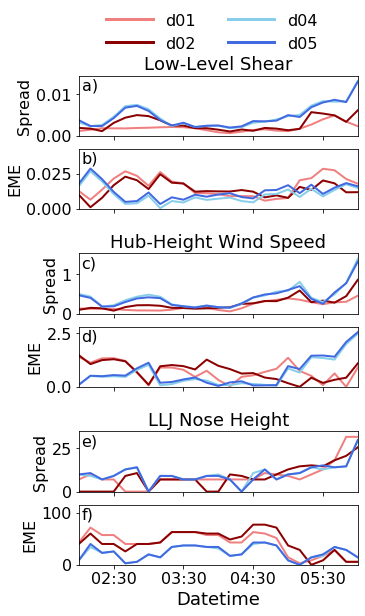

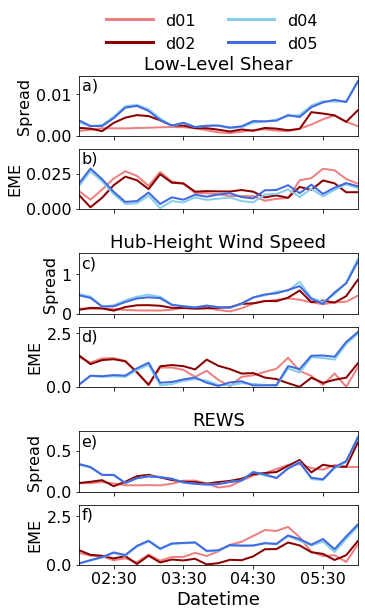

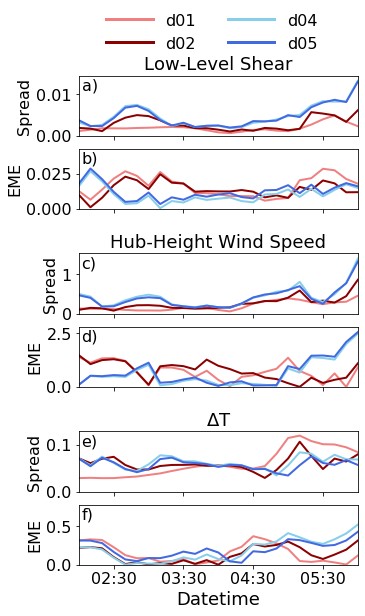

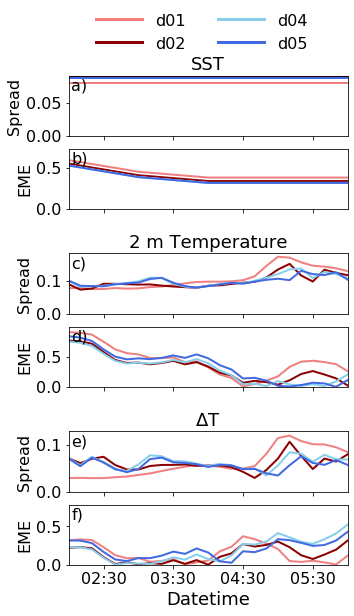

In [99]:
variable_groups = [['low_shear','hub_wspd','llj_height'],
                   ['low_shear','hub_wspd','rews'],
                   ['low_shear','hub_wspd','delT'],
                   ['tsk','t2','delT',]]


for variables in variable_groups:
    #plt_start = pd.to_datetime(case_start)
    plt_start = pd.to_datetime(case_start)
    plt_end = pd.to_datetime(case_end)

    fig = plt.figure(figsize=(5,9))
    gs1 = gridspec.GridSpec(6, 1)

    gs1.update(hspace=1)

    ax1 = plt.subplot(gs1[0,0])
    ax2 = plt.subplot(gs1[1,0], sharex=ax1)
    ax3 = plt.subplot(gs1[2,0], sharex=ax1)
    ax4 = plt.subplot(gs1[3,0], sharex=ax1) 
    ax5 = plt.subplot(gs1[4,0], sharex=ax1)
    ax6 = plt.subplot(gs1[5,0], sharex=ax1)

    ax = [ax1,ax2,ax3,ax4,ax5,ax6]
    for axi in ax[:-1]:
        axi.tick_params(labelbottom=False)

    #gs1.tight_layout(fig)

    for col in range(0,3):
        a1 = col*2
        a2 = a1+1
        pos1 = ax[a1].get_position()
        pos2 = ax[a2].get_position()

        points1 = pos1.get_points()
        points2 = pos2.get_points()

        mid_y = 0.5*(points1[0][1] + points2[1][1])

        points1[0][1] = mid_y + 0.01
        points2[1][1] = mid_y - 0.01

        pos1.set_points(points1)
        pos2.set_points(points2)

        ax[a1].set_position(pos1)
        ax[a2].set_position(pos2)
    
    lid = 'E06'

    xticks = pd.date_range(start=pd.to_datetime(case_start)+pd.to_timedelta(30,'min'),
                           end=pd.to_datetime(case_end)-pd.to_timedelta(30,'min'),
                           freq=pd.Timedelta('1h'))
    xticklabels = []
    for xtick in xticks: xticklabels += [str(xtick)[-8:-3]]


    sprd_min_dict = {}
    sprd_max_dict = {}
    eme_min_dict = {}
    eme_max_dict = {}
    for vv,varn in enumerate(variables):
        sprd_min_dict[varn] = 999
        sprd_max_dict[varn] = -999
        eme_min_dict[varn] = 999
        eme_max_dict[varn] = -999

    for dd,dom in enumerate(doms_of_interest):
    #for dd,dom in enumerate([1,2,4,5]):

        mean_ls = dom_dict[dom]['ls']
        ls = '-'

        dom_str = 'd0{}'.format(dom)
        ens_dom_ds = ens_dict[dom_str]
        data_toi = ens_dom_ds.sel(datetime=ptimes)
        data_avg_ds = ens_dom_ds.sel(datetime=slice(case_start,case_end)).mean(dim='datetime')

        cases_of_interest_dom = []
        for cc,case in enumerate(cases_of_interest):
            if dom_str in case:
                cases_of_interest_dom += [case]


        for vv,varn in enumerate(variables):
            
            if (dd == 10):
                err_str  = 'EME'
                sprd_str = 'Spread'
            else:
                err_str,sprd_str = None,None

            if dom >= 3:
                spr_c = les_spread
                err_c = les_eme
            else:
                spr_c = meso_spread
                err_c = meso_eme

            eme = ens_dom_ds['ens_error_{}'.format(varn)].dropna(how='all',dim='datetime')
            eme.plot(#c=err_c,
                     c=dom_dict[dom]['color'],
                     ax=ax[(vv*2)+1],
                     label=err_str,
                     #ls=mean_ls,
                     ls=ls,
                     lw=2.0)
            
            sprd = ens_dom_ds['ens_spread_{}'.format(varn)].dropna(how='all',dim='datetime')
            sprd.plot(#c=spr_c,
                      c=dom_dict[dom]['color'],
                      ax=ax[(vv*2)],
                      label=sprd_str,
                      #ls=mean_ls,
                      ls=ls,
                      lw=2.0)

            for axi in range(0,2):
                ax[vv*2 + axi].tick_params(labelsize=16)
                ax[vv*2 + axi].set_ylabel('')
                ax[vv*2 + axi].set_xlabel('')
                ax[vv*2 + axi].set_xticks(xticks)
                ax[vv*2 + axi].set_xticklabels(xticklabels,rotation=0,ha='center')
                if dd == 0:
                    ax[vv*2 + axi].text(0.01,0.96,'{})'.format(ascii_lowercase[vv*2 + axi]),
                                        ha='left',va='top',size=16,
                                        transform = ax[vv*2 + axi].transAxes)



            eme_min = eme.min()
            eme_max = eme.max()
            sprd_min = sprd.min()
            sprd_max = sprd.max()
            if eme_min < eme_min_dict[varn]: eme_min_dict[varn] = eme_min
            if eme_max > eme_max_dict[varn]: eme_max_dict[varn] = eme_max
            
            if sprd_min < sprd_min_dict[varn]: sprd_min_dict[varn] = sprd_min
            if sprd_max > sprd_max_dict[varn]: sprd_max_dict[varn] = sprd_max

            var_str = variable_dict[varn]['title']
            ax[vv*2].set_title('{}'.format(var_str),
                             size=18)

        for vv,varn in enumerate(variables):
            #if dd == 0:
            #    ens_dom_ds.sel(case='obs')[varn].dropna(how='all',dim='datetime').plot(ax=ax[0,vv],c='grey',ls='-',
            #                                                                       lw=3.0,zorder=101,
            #                                                                       label='Obs.')
            ax[vv].plot([pd.to_datetime(case_start),
                         pd.to_datetime(case_end)],[-100,-100],
                        c=dom_dict[dom]['color'],
                        ls=ls,
                        label=dom_str,
                        lw=3.0)#,marker='o')

    ax[0].legend(loc=(0.075,1.3),frameon=False,ncol=2,fontsize=16,handlelength=2.9)
    for vv,varn in enumerate(variables):
        eme_range = eme_max_dict[varn] - eme_min_dict[varn]
        sprd_range = sprd_max_dict[varn] - sprd_min_dict[varn]
        ax[vv*2].set_ylabel('Spread',size=16)
        ax[vv*2+1].set_ylabel('EME',size=16)
        #for axi in range(0,2):
        ##ax[vv].set_ylim(var_min_dict[varn] - var_range*0.1,var_max_dict[varn] + var_range*0.1)
        #    ax[vv*2 + axi].set_ylim(0.0,var_max_dict[varn] + var_range*0.1)
        sprd_range_fct = 0.1
        eme_range_fct = 0.1
        
        if (vv == 0) or (vv == 2):
            eme_range_fct = 0.5
        
        ax[vv*2].set_ylim(0.0,sprd_max_dict[varn]+sprd_range*sprd_range_fct)
        ax[vv*2+1].set_ylim(0.0,eme_max_dict[varn]+eme_range*eme_range_fct)
        
        
    ax[0].set_xlim(plt_start,plt_end)
    ax[-1].set_xlabel('Datetime',size=18)

    fig_name = '{}OnlySpreadError_{}_new'.format(save_dir,'_'.join(variables))
    if save_figs: 
        for save_type in ['.png','.pdf']: plt.savefig(fig_name+save_type,bbox_inches='tight')
    plt.show()

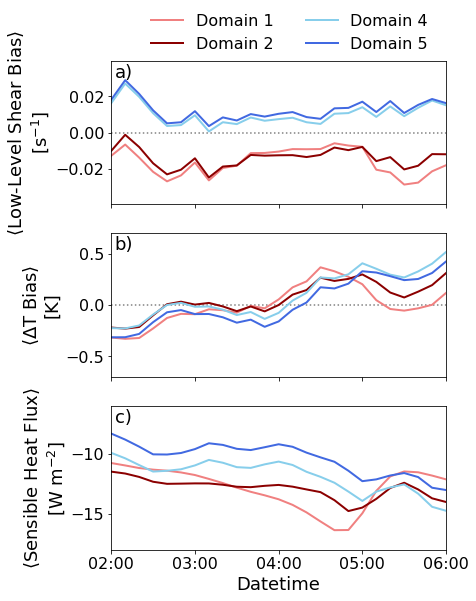

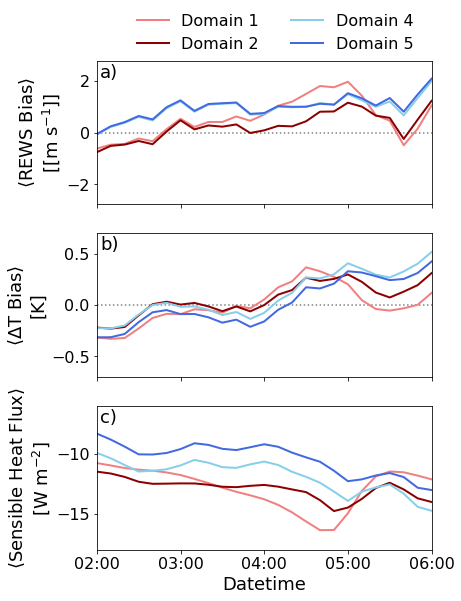

In [23]:
varnB = 'delT'

for varnA in ['low_shear','rews']:
    fig,ax = plt.subplots(nrows=3,figsize=(6,9),sharex=True)

    xticks = pd.date_range(start=pd.to_datetime(case_start),#+pd.to_timedelta(30,'min'),
                           end=pd.to_datetime(case_end),#-pd.to_timedelta(30,'min'),
                           freq=pd.Timedelta('1h'))
    xticklabels = []
    for xtick in xticks: xticklabels += [str(xtick)[-8:-3]]

    for dd,dom in enumerate(doms_of_interest):
        dom_str = 'd0{}'.format(dom)
        cases_of_interest_dom = []
        for case in ens_ds.case:
            if dom_str in str(case.data): cases_of_interest_dom += [str(case.data)]
        ens_dom_ds = ens_ds.sel(case=cases_of_interest_dom)
        
        vA = ens_dom_ds[varnA]
        biasA = vA - ens_ds.sel(case='obs')[varnA]
        bias_avgA = biasA.mean(dim='case')
        
        vB = ens_dom_ds[varnB]
        biasB = vB - ens_ds.sel(case='obs')[varnB]
        bias_avgB = biasB.mean(dim='case')

        bias_avgA.plot(ax=ax[0],
                       c=dom_dict[dom]['color'],
                       label='Domain {}'.format(dom),
                       lw=2.0)


        bias_avgB.plot(ax=ax[1],
                       c=dom_dict[dom]['color'],
                       label='Domain {}'.format(dom),
                       lw=2.0)
        
        dom_ds = wrf_ds_full.sel(case=cases_of_interest_dom)
        mean_ds = dom_ds.mean(dim='case')
        mean_ds.HFX.plot(ax=ax[2],
                         c=dom_dict[dom]['color'],
                         lw=2.0,
                         label='Domain {}'.format(dom))
        
        
        
    for axi in range(0,3):
        ax[axi].tick_params(labelsize=16)
        ax[axi].set_xticks(xticks)
        ax[axi].text(0.01,0.98,'{})'.format(ascii_lowercase[axi]),
                     ha='left',va='top',fontsize=18,
                     transform = ax[axi].transAxes)
        yabs_max = abs(max(ax[axi].get_ylim(), key=abs))*1.25
        if axi < 2:
            ax[axi].set_ylim(ymin=-yabs_max, ymax=yabs_max)
            ax[axi].axhline(0.0,alpha=0.5,ls=':',c='k',zorder=0)
            ax[axi].set_xlabel('',size=18)

        else:
            ax[axi].set_ylim(-18,-6)
            ax[axi].set_xlabel('Datetime',size=18)

        

        
    ax[2].set_xticklabels(xticklabels,rotation=0,ha='center')
    ax[2].set_xlim(pd.to_datetime(case_start),pd.to_datetime(case_end))
    ax[0].set_ylabel(r'$\langle${} Bias$\rangle$'.format(variable_dict[varnA]['title']) +\
                     '\n[{}]'.format(variable_dict[varnA]['units']),size=18)
    ax[1].set_ylabel(r'$\langle${} Bias$\rangle$'.format(variable_dict[varnB]['title'])+\
                                     '\n[{}]'.format(variable_dict[varnB]['units']),size=18)
    ax[2].set_ylabel(r'$\langle$Sensible Heat Flux$\rangle$'+'\n[W m$^{-2}$]',size=18)

    ax[0].legend(frameon=False,fontsize=16,ncol=2,loc=(0.1,1.02))



    fig_name = '{}Bias{}_Bias{}_wHFX'.format(save_dir,varnA,varnB)
    if save_figs: 
        for save_type in ['.png','.pdf']: plt.savefig(fig_name+save_type,bbox_inches='tight')

    plt.show()

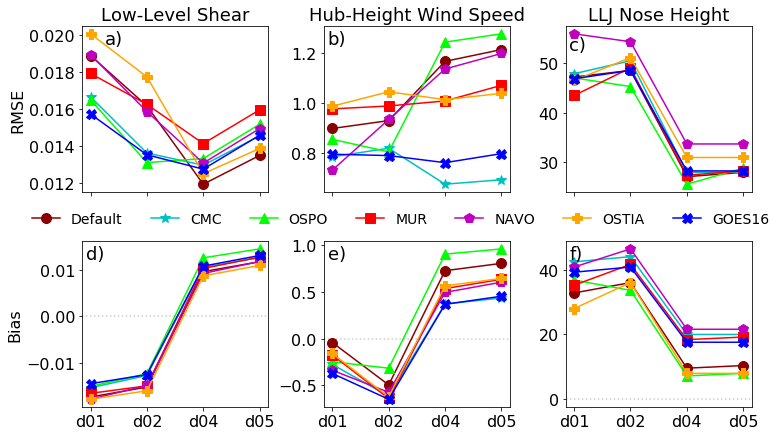

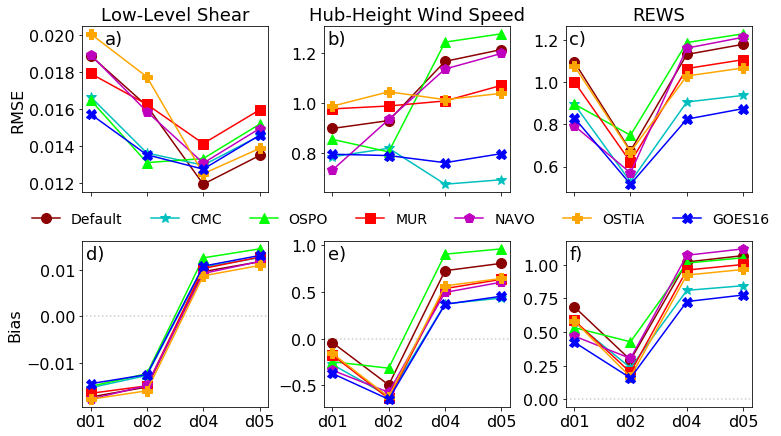

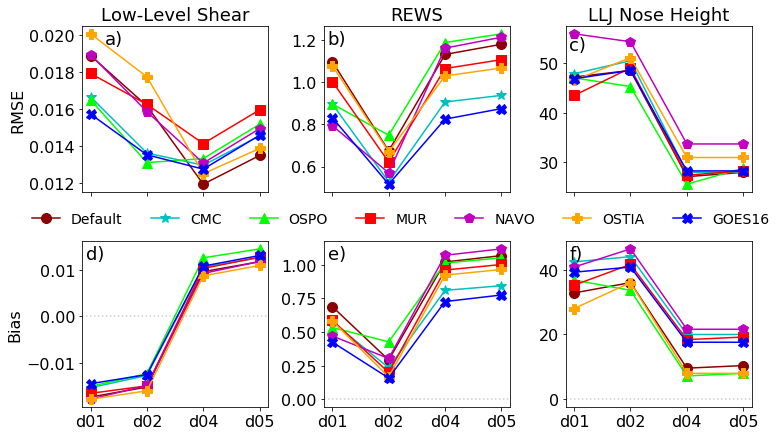

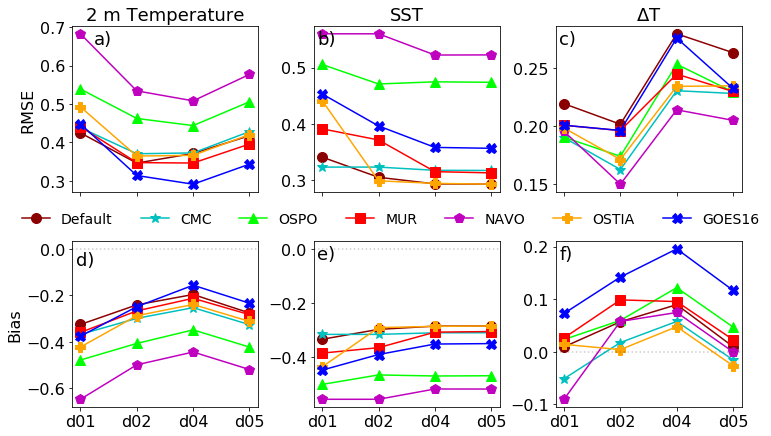

In [124]:
#variables = ['t2','sst','delT','low_shear','max_wspd','hub_wspd','llj_height']

variable_groups = [['low_shear','hub_wspd','llj_height'],
                   ['low_shear','hub_wspd','rews'],
                   ['low_shear','rews','llj_height'],
                   ['t2','tsk','delT',]]

#doms_of_interest = [1,2,3,4,5]

for variables in variable_groups:

    #plt_start = pd.to_datetime(case_start)
    plt_start = pd.to_datetime(case_start)
    plt_end = pd.to_datetime(case_end)

    fig,ax = plt.subplots(nrows=2,ncols=len(variables),figsize=(4*len(variables),7),sharex=True)
    plt.subplots_adjust(wspace=0.3,hspace=0.3)

    lid = 'E06'

    var_min_dict = {}
    var_max_dict = {}
    for vv,varn in enumerate(variables):
        var_min_dict[varn] = 999
        var_max_dict[varn] = -999

    cases_of_interest_dom = cases.copy()
    bias_dict = {}
    rmse_dict = {}

    for vv,varn in enumerate(variables):
        bias_dict[varn] = {}
        rmse_dict[varn] = {}
        for cc,case in enumerate(cases_of_interest_dom):
            case_str = case.replace('_{}'.format(dom_str),'')
            bias_dict[varn][case] = []
            rmse_dict[varn][case] = []
            for dd,dom in enumerate(doms_of_interest):
                mean_ls = dom_dict[dom]['ls']
                ls = '-'

                dom_str = 'd0{}'.format(dom)

                sim = ens_dict[dom_str].sel(case='{}_{}'.format(case,dom_str))[varn]
                obs = ens_ds.sel(case='obs')[varn]

                sim = sim.where(~np.isnan(obs)).dropna(how='all',dim='datetime')
                obs = obs.dropna(how='all',dim='datetime')

                sim = sim.sel(datetime=slice(case_start,case_end))
                obs = obs.sel(datetime=slice(case_start,case_end))

                bias = float(sim.mean() - obs.mean())
                rmse = float(np.sqrt(((sim - obs)**2).mean()))
                bias_dict[varn][case] += [bias]
                rmse_dict[varn][case] += [rmse]
                
            if vv == 0:
                plt_lbl = case_dict[case_str]['case_name']
                if 'DFLT' in case:
                    plt_lbl = 'Default'
                else:
                    plt_lbl = case_dict[case_str]['sst']
            else:
                plt_lbl = None
                
            ax[0,vv].plot(range(0,len(doms_of_interest)),
                          rmse_dict[varn][case],
                          c=case_dict[case_str]['color'],
                          marker=marker_dict[case_str],
                          markersize=10,
                          ls='-',
                          label=plt_lbl)
            ax[1,vv].plot(range(0,len(doms_of_interest)),
                          bias_dict[varn][case],
                          c=case_dict[case_str]['color'],
                          marker=marker_dict[case_str],
                          markersize=10,
                          ls='-',
                          label=plt_lbl)
            

        xlbl = []
        for dd,dom in enumerate(doms_of_interest):
            xlbl += ['d0{}'.format(dom)]
        ax[1,vv].set_xticks(np.arange(0,len(doms_of_interest)))
        ax[1,vv].set_xticklabels(xlbl)
        for axi in range(0,2):
            ax[axi,vv].tick_params(labelsize=16)
            txt_x = 0.02
            txt_y = 0.98
            if (varn == 'low_shear') and (axi == 0): txt_x = 0.12
            if (varn == 'llj_height') and (axi == 0): txt_y = 0.94
            if (varn == 't2') and (axi == 0): txt_x = 0.12
            if (varn == 't2') and (axi == 1): txt_y = 0.94
            ax[axi,vv].text(txt_x,txt_y,'{})'.format(ascii_lowercase[vv + axi*3]),
                            ha='left',va='top',fontsize=18,
                            transform = ax[axi,vv].transAxes)
        var_str = variable_dict[varn]['title']
        ax[0,vv].set_title(var_str,size=18)

        ax[1,vv].axhline(0.0,c='k',alpha=0.2,ls=':')
    ax[0,0].set_ylabel('RMSE',size=16)
    ax[1,0].set_ylabel('Bias',size=16)
    ax[1,0].legend(frameon=False,ncol=7,fontsize=14,loc=(-0.3,1.06))
    fig_name = '{}ErrorBias_{}'.format(save_dir,'_'.join(variables))

    if save_figs: 
        for save_type in ['.png','.pdf']: plt.savefig(fig_name+save_type,bbox_inches='tight')
    plt.show()

In [25]:
wefwef

NameError: name 'wefwef' is not defined

# Unused Plots:

In [ ]:
xticks = pd.date_range(start=pd.to_datetime(case_start),#+pd.to_timedelta(30,'min'),
                       end=pd.to_datetime(case_end),#-pd.to_timedelta(30,'min'),
                       freq=pd.Timedelta('1h'))
xticklabels = []
for xtick in xticks: xticklabels += [str(xtick)[-8:-3]]

plt.figure(figsize=(6,3))

varn = 'HFX'

for dd,dom in enumerate(doms_of_interest):
    dom_str = 'd0{}'.format(dom)
    cases_of_interest_dom = []
    for case in wrf_ds_full.case:
        if dom_str in str(case.data): cases_of_interest_dom += [str(case.data)]

    dom_ds = wrf_ds_full.sel(case=cases_of_interest_dom)
    mean_ds = dom_ds.mean(dim='case')
    mean_ds[varn].plot(c=dom_dict[dom]['color'],
                     lw=2.0,
                     label='Domain {}'.format(dom))
plt.legend(frameon=False,fontsize=16,ncol=2,loc=(0.05,1.01))
plt.tick_params(labelsize=16)
plt.xlim(pd.to_datetime(case_start),pd.to_datetime(case_end))
plt.ylabel('Sensible Heat Flux\n[W m$^{-2}$]',size=16)
plt.xlabel('Datetime',size=16)

plt.xticks(xticks,xticklabels,rotation=0,ha='center')


fig_name = '{}HFX'.format(save_dir)
#if save_figs: 
#    for save_type in ['.png','.pdf']: plt.savefig(fig_name+save_type,bbox_inches='tight')

plt.show()

In [ ]:
varnB = 'delT'

for varnA in ['low_shear','rews']:
    fig,ax = plt.subplots(nrows=2,figsize=(6,6),sharex=True)

    xticks = pd.date_range(start=pd.to_datetime(case_start),#+pd.to_timedelta(30,'min'),
                           end=pd.to_datetime(case_end),#-pd.to_timedelta(30,'min'),
                           freq=pd.Timedelta('1h'))
    xticklabels = []
    for xtick in xticks: xticklabels += [str(xtick)[-8:-3]]

    for dd,dom in enumerate(doms_of_interest):
        dom_str = 'd0{}'.format(dom)
        cases_of_interest_dom = []
        for case in ens_ds.case:
            if dom_str in str(case.data): cases_of_interest_dom += [str(case.data)]
        ens_dom_ds = ens_ds.sel(case=cases_of_interest_dom)
        
        vA = ens_dom_ds[varnA]
        biasA = vA - ens_ds.sel(case='obs')[varnA]
        bias_avgA = biasA.mean(dim='case')
        
        vB = ens_dom_ds[varnB]
        biasB = vB - ens_ds.sel(case='obs')[varnB]
        bias_avgB = biasB.mean(dim='case')

        bias_avgA.plot(ax=ax[0],
                       c=dom_dict[dom]['color'],
                       label='Domain {}'.format(dom),
                       lw=2.0)


        bias_avgB.plot(ax=ax[1],
                       c=dom_dict[dom]['color'],
                       label='Domain {}'.format(dom),
                       lw=2.0)
    for axi in range(0,2):
        ax[axi].tick_params(labelsize=16)
        ax[axi].set_xticks(xticks)
        ax[axi].text(0.01,0.98,'{})'.format(ascii_lowercase[axi]),
                     ha='left',va='top',fontsize=18,
                     transform = ax[axi].transAxes)
        yabs_max = abs(max(ax[axi].get_ylim(), key=abs))*1.25
        ax[axi].set_ylim(ymin=-yabs_max, ymax=yabs_max)
        ax[axi].axhline(0.0,alpha=0.5,ls=':',c='k',zorder=0)

    ax[1].set_xticklabels(xticklabels,rotation=0,ha='center')
    ax[1].set_xlim(pd.to_datetime(case_start),pd.to_datetime(case_end))
    ax[0].set_ylabel(r'$\langle${} Bias$\rangle$'.format(variable_dict[varnA]['title']) +\
                     '\n[{}]'.format(variable_dict[varnA]['units']),size=18)
    ax[1].set_ylabel(r'$\langle${} Bias$\rangle$ [{}]'.format(variable_dict[varnB]['title'],
                                     variable_dict[varnB]['units']),size=18)

    ax[0].set_xlabel('',size=18)
    ax[1].set_xlabel('Datetime',size=18)
    ax[0].legend(frameon=False,fontsize=16,ncol=2,loc=(0.1,1.02))



    fig_name = '{}Bias{}_Bias{}'.format(save_dir,varnA,varnB)
    if save_figs: 
        for save_type in ['.png','.pdf']: plt.savefig(fig_name+save_type,bbox_inches='tight')

    plt.show()

In [ ]:
#variables = ['t2','sst','delT','low_shear','max_wspd','hub_wspd','llj_height']

variable_groups = [['low_shear','hub_wspd','llj_height'],
                   ['low_shear','hub_wspd','rews'],
                   ['low_shear','rews','llj_height'],
                   ['t2','tsk','delT',]]

for variables in variable_groups:

    #plt_start = pd.to_datetime(case_start)
    plt_start = pd.to_datetime(case_start)
    plt_end = pd.to_datetime(case_end)

    fig,ax = plt.subplots(nrows=2,ncols=len(variables),figsize=(4*len(variables),7),sharex=True)
    plt.subplots_adjust(wspace=0.3,hspace=0.3)

    lid = 'E06'

    var_min_dict = {}
    var_max_dict = {}
    for vv,varn in enumerate(variables):
        var_min_dict[varn] = 999
        var_max_dict[varn] = -999

    cases_of_interest_dom = cases.copy()
    bias_dict = {}
    rmse_dict = {}

    for vv,varn in enumerate(variables):
        bias_dict[varn] = {}
        rmse_dict[varn] = {}
        for cc,case in enumerate(cases_of_interest_dom):
            case_str = case.replace('_{}'.format(dom_str),'')
            bias_dict[varn][case] = []
            rmse_dict[varn][case] = []
            for dd,dom in enumerate(doms_of_interest):
                mean_ls = dom_dict[dom]['ls']
                ls = '-'

                dom_str = 'd0{}'.format(dom)

                sim = ens_dict[dom_str].sel(case='{}_{}'.format(case,dom_str))[varn]
                obs = ens_ds.sel(case='obs')[varn]

                sim = sim.where(~np.isnan(obs)).dropna(how='all',dim='datetime')
                obs = obs.dropna(how='all',dim='datetime')

                sim = sim.sel(datetime=slice(case_start,case_end))
                obs = obs.sel(datetime=slice(case_start,case_end))

                bias = float(sim.mean() - obs.mean())
                rmse = float(np.sqrt(((sim - obs)**2).mean()))
                bias_dict[varn][case] += [bias]
                rmse_dict[varn][case] += [rmse]
                
            if vv == 0:
                plt_lbl = case_dict[case_str]['case_name']
                if 'DFLT' in case:
                    plt_lbl = 'Default'
                else:
                    plt_lbl = case_dict[case_str]['sst']
            else:
                plt_lbl = None
                
            ax[0,vv].plot(range(0,len(doms_of_interest)),
                          rmse_dict[varn][case],
                          c=case_dict[case_str]['color'],
                          markersize=10,
                          ls='-',
                          label=plt_lbl)
            ax[1,vv].plot(range(0,len(doms_of_interest)),
                          bias_dict[varn][case],
                          c=case_dict[case_str]['color'],
                          markersize=10,
                          ls='-',
                          label=plt_lbl)
            
            
            for ss in range(0,2):
                if ss == 0:
                    marker = 'o'
                    fc = 'w'
                    s = 120
                else:
                    marker = marker_dict[case_str]
                    s = 30
                ax[0,vv].scatter(range(0,len(doms_of_interest)),
                                 rmse_dict[varn][case],
                                  ec=case_dict[case_str]['color'],
                                  fc=fc,
                                  s=s,
                                  marker=marker,
                                  #label=plt_lbl,
                                  zorder=200+ss)
                ax[1,vv].scatter(range(0,len(doms_of_interest)),
                                 bias_dict[varn][case],
                                  ec=case_dict[case_str]['color'],
                                  fc=fc,
                                  s=s,
                                  marker=marker,
                                  #label=plt_lbl,
                                  zorder=200+ss)
            

        xlbl = []
        for dd,dom in enumerate(doms_of_interest):
            xlbl += ['d0{}'.format(dom)]
        ax[1,vv].set_xticks(np.arange(0,len(doms_of_interest)))
        ax[1,vv].set_xticklabels(xlbl)
        for axi in range(0,2):
            ax[axi,vv].tick_params(labelsize=16)
            txt_x = 0.02
            txt_y = 0.98
            if (varn == 'low_shear') and (axi == 0): txt_x = 0.12
            if (varn == 'llj_height') and (axi == 0): txt_y = 0.94
            if (varn == 't2') and (axi == 0): txt_x = 0.12
            if (varn == 't2') and (axi == 1): txt_y = 0.94
            ax[axi,vv].text(txt_x,txt_y,'{})'.format(ascii_lowercase[vv + axi*3]),
                            ha='left',va='top',fontsize=18,
                            transform = ax[axi,vv].transAxes)
        var_str = variable_dict[varn]['title']
        ax[0,vv].set_title(var_str,size=18)

        ax[1,vv].axhline(0.0,c='k',alpha=0.2,ls=':')
    ax[0,0].set_ylabel('Error',size=16)
    ax[1,0].set_ylabel('Bias',size=16)
    ax[1,0].legend(frameon=False,ncol=7,fontsize=14,loc=(-0.3,1.06))
    fig_name = '{}ErrorBias_{}'.format(save_dir,'_'.join(variables))

    if save_figs: 
        for save_type in ['.png','.pdf']: plt.savefig(fig_name+save_type,bbox_inches='tight')
    plt.show()

In [ ]:
fig,ax = plt.subplots(figsize=(6,3))

xticks = pd.date_range(start=pd.to_datetime(case_start),#+pd.to_timedelta(30,'min'),
                       end=pd.to_datetime(case_end),#-pd.to_timedelta(30,'min'),
                       freq=pd.Timedelta('1h'))
xticklabels = []
for xtick in xticks: xticklabels += [str(xtick)[-8:-3]]

varn = 'delT'

for dd,dom in enumerate(doms_of_interest):
    dom_str = 'd0{}'.format(dom)
    cases_of_interest_dom = []
    for case in ens_ds.case:
        if dom_str in str(case.data): cases_of_interest_dom += [str(case.data)]
    ens_dom_ds = ens_ds.sel(case=cases_of_interest_dom)
    delT = ens_dom_ds[varn]
    bias = delT - ens_ds.sel(case='obs')[varn]
    bias_avg = bias.mean(dim='case')
    bias_avg.plot(c=dom_dict[dom]['color'],
                  label='Domain {}'.format(dom),
                  lw=2.0)
plt.tick_params(labelsize=16)
plt.axhline(0.0,alpha=0.5,ls=':',c='k',zorder=0)
ax.set_xticks(xticks)
ax.set_xticklabels(xticklabels,rotation=0,ha='center')
plt.xlim(case_start,case_end)
plt.ylabel('{} Bias [{}]'.format(variable_dict[varn]['title'],
                                 variable_dict[varn]['units']),size=18)
plt.xlabel('Datetime',size=18)
plt.legend(frameon=False,fontsize=16,ncol=2,loc=(0.05,1.02))

yabs_max = abs(max(ax.get_ylim(), key=abs))
ax.set_ylim(ymin=-yabs_max, ymax=yabs_max)

fig_name = '{}Bias_{}'.format(save_dir,varn)
if save_figs: 
    for save_type in ['.png','.pdf']: plt.savefig(fig_name+save_type,bbox_inches='tight')

plt.show()

In [ ]:
variable_groups = [['low_shear','hub_wspd','llj_height'],
                   ['max_wspd','delT','t2',]]


for variables in variable_groups:
    #plt_start = pd.to_datetime(case_start)
    plt_start = pd.to_datetime(case_start)
    plt_end = pd.to_datetime(case_end)

    fig,ax = plt.subplots(nrows=2,ncols=len(variables),figsize=(4.5*len(variables),6),sharex=True)
    plt.subplots_adjust(wspace=0.3,hspace=0.3)
    lid = 'E06'

    xticks = pd.date_range(start=pd.to_datetime(case_start),
                           end=pd.to_datetime(case_end),
                           freq=pd.Timedelta('2h'))
    xticklabels = []
    for xtick in xticks: xticklabels += [str(xtick)[-8:-3]]


    var_min_dict = {}
    var_max_dict = {}
    for vv,varn in enumerate(variables):
        var_min_dict[varn] = 999
        var_max_dict[varn] = -999

    for dd,dom in enumerate(doms_of_interest):
    #for dd,dom in enumerate([1,2,4,5]):

        mean_ls = dom_dict[dom]['ls']
        ls = '-'

        dom_str = 'd0{}'.format(dom)
        ens_dom_ds = ens_dict[dom_str]
        data_toi = ens_dom_ds.sel(datetime=ptimes)
        data_avg_ds = ens_dom_ds.sel(datetime=slice(case_start,case_end)).mean(dim='datetime')

        cases_of_interest_dom = []
        for cc,case in enumerate(cases_of_interest):
            if dom_str in case:
                cases_of_interest_dom += [case]

        for cc,case in enumerate(cases_of_interest_dom):
            case_str = case.replace('_{}'.format(dom_str),'')

            for vv,varn in enumerate(variables):
                case_str = case.replace('_{}'.format(dom_str),'')
                if dd == 0:
                    plt_lbl = case_dict[case_str]['case_name']
                    if 'DFLT' in case:
                        plt_lbl = 'Default'
                    else:
                        plt_lbl = case_dict[case_str]['sst']
                else:
                    plt_lbl = None
                ens_dom_ds.sel(case=case)[varn].plot(ax=ax[0,vv],c=case_dict[case_str]['color'],
                                                     ls=mean_ls,lw=2.0,label=plt_lbl,
                                                     alpha=0.5)

                ens_dom_ds['ens_mean_{}'.format(varn)].plot(c='k',lw=3.0,ax=ax[0,vv],ls=mean_ls,alpha=1.0,zorder=100)

                if (dd == 10):
                    err_str  = 'EME'
                    sprd_str = 'Spread'
                else:
                    err_str,sprd_str = None,None

                if dom >= 3:
                    spr_c = les_spread
                    err_c = les_eme
                else:
                    spr_c = meso_spread
                    err_c = meso_eme

                ens_dom_ds['ens_error_{}'.format(varn)].dropna(how='all',dim='datetime').plot(c=err_c,
                                                                                              ax=ax[1,vv],
                                                                                              label=err_str,
                                                                                              ls=mean_ls,
                                                                                              lw=2.0)
                ens_dom_ds['ens_spread_{}'.format(varn)].plot(c=spr_c,ax=ax[1,vv],label=sprd_str,ls=mean_ls,lw=2.0)


                for axi in range(0,2):
                    ax[axi,vv].tick_params(labelsize=16)
                    ax[axi,vv].set_ylabel('')
                    ax[axi,vv].set_xlabel('')
                    ax[axi,vv].set_xticks(xticks)
                    ax[axi,vv].set_xticklabels(xticklabels,rotation=0,ha='center')

                var_min = ens_dom_ds[varn].min()
                var_max = ens_dom_ds[varn].max()
                if var_min < var_min_dict[varn]: var_min_dict[varn] = var_min
                if var_max > var_max_dict[varn]: var_max_dict[varn] = var_max

                var_str = variable_dict[varn]['title']
                ax[0,vv].set_title(var_str,size=18)
                ax[1,vv].set_title('')

        for vv,varn in enumerate(variables):
            if dd == 0:
                ens_dom_ds.sel(case='obs')[varn].dropna(how='all',dim='datetime').plot(ax=ax[0,vv],c='grey',ls='-',
                                                                                   lw=3.0,zorder=101,
                                                                                   label='Obs.')
            ax[0,vv].plot([pd.to_datetime(case_start),
                       pd.to_datetime(case_end)],[-1,-1],c='k',ls=mean_ls,label=dom_str,lw=3.0)#,marker='o')

    ax[0,0].legend(loc=(0.0,1.2),frameon=False,ncol=6,fontsize=15,handlelength=2.9)
    for vv,varn in enumerate(variables):
        var_range = var_max_dict[varn] - var_min_dict[varn]
        ax[0,vv].set_ylim(var_min_dict[varn] - var_range*0.1,var_max_dict[varn] + var_range*0.2)
        
        for axi in range(0,2):
            ax[axi,vv].text(0.02,0.98,'{})'.format(ascii_lowercase[vv + axi*3]),
                       ha='left',va='top',fontsize=16,
                       transform = ax[axi,vv].transAxes)
    ax[0,0].set_xlim(plt_start,plt_end)
    ax[1,1].set_xlabel('Datetime',size=18)

    # Complex legend...
    leg_x = 0.1
    leg_y = 1.03
    axi_for_legend = (1,1)
    ax[axi_for_legend].legend([(meso_spread,les_spread), (meso_eme,les_eme)], ['Spread', 'EME'],
                   handler_map={tuple: AnyObjectHandler()},ncol=2,fontsize=16,
                   frameon=False,loc=(leg_x,leg_y),handletextpad=0.2,labelspacing=1.6)
    ax[axi_for_legend].text(leg_x + 0.11,leg_y + 0.125,'Meso',c=meso_spread,ha='center',va='bottom',fontsize=14,
                 transform = ax[axi_for_legend].transAxes)
    ax[axi_for_legend].text(leg_x + 0.11,leg_y + 0.085,'LES',c=les_spread,ha='center',va='top',fontsize=14,
                 transform = ax[axi_for_legend].transAxes)

    ax[axi_for_legend].text(leg_x + 0.7,leg_y + 0.125,'Meso',c=meso_eme,ha='center',va='bottom',fontsize=14,
                 transform = ax[axi_for_legend].transAxes)
    ax[axi_for_legend].text(leg_x + 0.7,leg_y + 0.085,'LES',c=les_eme,ha='center',va='top',fontsize=14,
                 transform = ax[axi_for_legend].transAxes)

    fig_name = '{}SpreadError_{}'.format(save_dir,'_'.join(variables))
    if save_figs: 
        for save_type in ['.png','.pdf']: plt.savefig(fig_name+save_type,bbox_inches='tight')
    plt.show()

In [ ]:
variable_groups = [['low_shear','hub_wspd','llj_height'],
                   ['max_wspd','delT','t2',]]

for variables in variable_groups:
    #plt_start = pd.to_datetime(case_start)
    plt_start = pd.to_datetime(case_start)
    plt_end = pd.to_datetime(case_end)

    fig,ax = plt.subplots(nrows=len(variables),ncols=1,figsize=(6,2.5*len(variables)),sharex=True)
    plt.subplots_adjust(wspace=0.3,hspace=0.3)
    lid = 'E06'

    xticks = pd.date_range(start=pd.to_datetime(case_start)+pd.to_timedelta(30,'min'),
                           end=pd.to_datetime(case_end)-pd.to_timedelta(30,'min'),
                           freq=pd.Timedelta('1h'))
    xticklabels = []
    for xtick in xticks: xticklabels += [str(xtick)[-8:-3]]


    var_min_dict = {}
    var_max_dict = {}
    for vv,varn in enumerate(variables):
        var_min_dict[varn] = 999
        var_max_dict[varn] = -999

    for dd,dom in enumerate(doms_of_interest):
    #for dd,dom in enumerate([1,2,4,5]):

        mean_ls = dom_dict[dom]['ls']
        ls = '-'

        dom_str = 'd0{}'.format(dom)
        ens_dom_ds = ens_dict[dom_str]
        data_toi = ens_dom_ds.sel(datetime=ptimes)
        data_avg_ds = ens_dom_ds.sel(datetime=slice(case_start,case_end)).mean(dim='datetime')

        cases_of_interest_dom = []
        for cc,case in enumerate(cases_of_interest):
            if dom_str in case:
                cases_of_interest_dom += [case]

        for cc,case in enumerate(cases_of_interest_dom):
            case_str = case.replace('_{}'.format(dom_str),'')

            for vv,varn in enumerate(variables):
                case_str = case.replace('_{}'.format(dom_str),'')
                if dd == 0:
                    plt_lbl = case_dict[case_str]['case_name']
                    if 'DFLT' in case:
                        plt_lbl = 'Default'
                    else:
                        plt_lbl = case_dict[case_str]['sst']
                else:
                    plt_lbl = None
                #ens_dom_ds.sel(case=case)[varn].plot(ax=ax[0,vv],c=case_dict[case_str]['color'],
                #                                     ls=mean_ls,lw=2.0,label=plt_lbl,
                #                                     alpha=0.5)
                #ens_dom_ds['ens_mean_{}'.format(varn)].plot(c='k',lw=3.0,ax=ax[0,vv],ls=mean_ls,alpha=1.0,zorder=100)

                if (dd == 10):
                    err_str  = 'EME'
                    sprd_str = 'Spread'
                else:
                    err_str,sprd_str = None,None

                if dom >= 3:
                    spr_c = les_spread
                    err_c = les_eme
                else:
                    spr_c = meso_spread
                    err_c = meso_eme

                ens_dom_ds['ens_error_{}'.format(varn)].dropna(how='all',dim='datetime').plot(c=err_c,
                                                                                              ax=ax[vv],
                                                                                              label=err_str,
                                                                                              ls=mean_ls,
                                                                                              lw=2.0)
                ens_dom_ds['ens_spread_{}'.format(varn)].plot(c=spr_c,ax=ax[vv],label=sprd_str,ls=mean_ls,lw=2.0)

                ax[vv].tick_params(labelsize=16)
                ax[vv].set_ylabel('')
                ax[vv].set_xlabel('')
                ax[vv].set_xticks(xticks)
                ax[vv].set_xticklabels(xticklabels,rotation=0,ha='center')

                var_min = ens_dom_ds['ens_error_{}'.format(varn)].min()
                var_max = ens_dom_ds['ens_error_{}'.format(varn)].max()
                if var_min < var_min_dict[varn]: var_min_dict[varn] = var_min
                if var_max > var_max_dict[varn]: var_max_dict[varn] = var_max

                var_str = variable_dict[varn]['title']
                ax[vv].set_title('{}) {}'.format(ascii_lowercase[vv],var_str),
                                 size=18,ha='left',x=0.0)

        for vv,varn in enumerate(variables):
            #if dd == 0:
            #    ens_dom_ds.sel(case='obs')[varn].dropna(how='all',dim='datetime').plot(ax=ax[0,vv],c='grey',ls='-',
            #                                                                       lw=3.0,zorder=101,
            #                                                                       label='Obs.')
            ax[vv].plot([pd.to_datetime(case_start),
                         pd.to_datetime(case_end)],[-100,-100],c='k',ls=mean_ls,label=dom_str,lw=3.0)#,marker='o')

    ax[0].legend(loc=(0.0,1.3),frameon=False,ncol=2,fontsize=15,handlelength=2.9)
    for vv,varn in enumerate(variables):
        var_range = var_max_dict[varn] - var_min_dict[varn]
        #ax[vv].set_ylim(var_min_dict[varn] - var_range*0.1,var_max_dict[varn] + var_range*0.1)
        ax[vv].set_ylim(0.0,var_max_dict[varn] + var_range*0.1)
        ax[vv].set_ylabel('[{}]'.format(variable_dict[varn]['units']),size=18)
    ax[0].set_xlim(plt_start,plt_end)
    ax[2].set_xlabel('Datetime',size=18)

    # Complex legend...
    leg_x = 0.7
    leg_y = 2.4
    axi_for_legend = (1)
    ax[axi_for_legend].legend([(meso_spread,les_spread), (meso_eme,les_eme)], ['Spread', 'EME'],
                   handler_map={tuple: AnyObjectHandler()},ncol=1,fontsize=16,
                   frameon=False,loc=(leg_x,leg_y),handletextpad=0.2,labelspacing=1.6)
    ax[axi_for_legend].text(leg_x + 0.065,leg_y + 0.502,'Meso',c=meso_spread,ha='center',va='bottom',fontsize=14,
                 transform = ax[axi_for_legend].transAxes)
    ax[axi_for_legend].text(leg_x + 0.065,leg_y + 0.462,'LES',c=les_spread,ha='center',va='top',fontsize=14,
                 transform = ax[axi_for_legend].transAxes)

    ax[axi_for_legend].text(leg_x + 0.065,leg_y + 0.14,'Meso',c=meso_eme,ha='center',va='bottom',fontsize=14,
                 transform = ax[axi_for_legend].transAxes)
    ax[axi_for_legend].text(leg_x + 0.065,leg_y + 0.1,'LES',c=les_eme,ha='center',va='top',fontsize=14,
                 transform = ax[axi_for_legend].transAxes)

    fig_name = '{}OnlySpreadError_{}'.format(save_dir,'_'.join(variables))
    if save_figs: 
        for save_type in ['.png','.pdf']: plt.savefig(fig_name+save_type,bbox_inches='tight')
    plt.show()

In [ ]:
# Pick the time period of interest and average statistics over this period?
#plt_start = pd.to_datetime(case_start)
plt_start = pd.to_datetime(case_start)
plt_end = pd.to_datetime(case_end)

fig,ax = plt.subplots(ncols=2,figsize=(10,5),sharey=True)

varn = 'wspd'

for dd,dom in enumerate(doms_of_interest):
#for dd,dom in enumerate([1,2,4,5]):
    
    mean_ls = dom_dict[dom]['ls']
    ls = '-'
    
    dom_str = 'd0{}'.format(dom)
    ens_dom_ds = ens_dict[dom_str]
    data_toi = ens_dom_ds.sel(datetime=slice(plt_start,plt_end)).mean(dim='datetime')

    cases_of_interest_dom = []
    for cc,case in enumerate(cases_of_interest):
        if dom_str in case:
            cases_of_interest_dom += [case]

    for cc,case in enumerate(cases_of_interest_dom):
        case_str = case.replace('_{}'.format(dom_str),'')

        if (dd == 0):
            plt_lbl = case_dict[case_str]['case_name']
            if 'DFLT' in case:
                plt_lbl = 'Default'
            else:
                plt_lbl = case_dict[case_str]['sst']
        else:
            plt_lbl = None
        data_toi.sel(case=case)[varn].plot(y='level',ax=ax[0],
                                           c=case_dict[case_str]['color'],
                                           ls=mean_ls,
                                           lw=2.0,
                                           label=plt_lbl)

    data_toi['ens_mean_{}'.format(varn)].plot(y='level',
                                              c='k',
                                              lw=4.0,
                                              ax=ax[0],
                                              ls=mean_ls,
                                              alpha=1.0)
    data_toi.sel(case='obs')[varn].dropna(how='all',dim='level').plot(y='level',
                                                                      ax=ax[0],
                                                                      c='grey',
                                                                      ls=ls,
                                                                      lw=3.0)

    if dd == 0:
        err_str  = 'EME'
        sprd_str = 'Spread'
    else:
        err_str = None
        sprd_str = None

    if dom >= 3:
        spr_c = les_spread
        err_c = les_eme
    else:
        spr_c = meso_spread
        err_c = meso_eme
        
    data_toi['ens_error_{}'.format(varn)].dropna(how='all',dim='level').plot(y='level',
                                                                             c=err_c,
                                                                             ax=ax[1],
                                                                             label=err_str,
                                                                             ls=mean_ls,
                                                                             lw=2.0,
                                                                             marker='o')
    data_toi['ens_spread_{}'.format(varn)].plot(y='level',
                                                c=spr_c,
                                                ax=ax[1],
                                                label=sprd_str,
                                                ls=mean_ls,
                                                lw=2.0,
                                                marker='o')
    for axi in range(0,2):
        ax[axi].tick_params(labelsize=16)
        ax[axi].set_ylabel('')
        ax[axi].set_xlabel('')
        ax[axi].set_title('')

    var_min = ens_ds[varn].min()
    var_max = ens_ds[varn].max()
    var_range = var_max - var_min
    #ax[0].set_xlim(var_min - var_range*0.1,var_max + var_range*0.1)
    var_min,var_max = 5,18
    ax[0].set_xlim(var_min,var_max)
    if varn == 'delT':
        var_str = '∆T'
    else:
        var_str = varn.upper()

    if dd == 0:
        ax[0].plot([-10,-11],[1,1],c='grey',ls=ls,label='Obs.',lw=3.0,marker='o')
    ax[0].plot([-10,-11],[1,1],c='k',ls=mean_ls,label=dom_str,lw=3.0,marker='o')

    ax[0].set_ylabel('Height [m]',size=18)
    ax[1].set_xlim(-0.1,2.8)

ax[0].text(0.02,0.98,'E06',size=22,va='top',transform=ax[0].transAxes)
ax[0].set_xlabel('Wind Speed [m s$^{-1}$]',size=16)
ax[1].set_xlabel('[m s$^{-1}$]',size=16)
ax[0].set_ylim(15,205)

ax[0].legend(loc=(-0.1,1.01),frameon=False,ncol=5,fontsize=16,handlelength=2.9)


# Complex legend...
leg_x = 1.01
leg_y = 0.7
ax[1].legend([(meso_spread,les_spread), (meso_eme,les_eme)], ['Spread', 'EME'],
               handler_map={tuple: AnyObjectHandler()},ncol=1,fontsize=16,
               frameon=False,loc=(leg_x,leg_y),handletextpad=0.2,labelspacing=1.6)
ax[1].text(leg_x + 0.09,leg_y + 0.215,'Meso',c=meso_spread,ha='center',va='bottom',fontsize=14,
             transform = ax[1].transAxes)
ax[1].text(leg_x + 0.09,leg_y + 0.19,'LES',c=les_spread,ha='center',va='top',fontsize=14,
             transform = ax[1].transAxes)

ax[1].text(leg_x + 0.09,leg_y + 0.065,'Meso',c=meso_eme,ha='center',va='bottom',fontsize=14,
             transform = ax[1].transAxes)
ax[1].text(leg_x + 0.09,leg_y + 0.04,'LES',c=les_eme,ha='center',va='top',fontsize=14,
             transform = ax[1].transAxes)

#ax[1].legend(frameon=False,loc=(0.55,0.55),fontsize=16,ncol=1)
plt.suptitle('Mean between {0:02d} and {1:02d} Z on {2}/{3}'.format(plt_start.hour,plt_end.hour,plt_start.month,plt_start.day),
             y=1.15,size=22)
fig_name = '{}SpreadErrorTotalAvg_wspd'.format(save_dir)
if save_figs: 
    for save_type in ['.png','.pdf']: plt.savefig(fig_name+save_type,bbox_inches='tight')
plt.show()

In [ ]:
# Pick the time period of interest and average statistics over this period?
#plt_start = pd.to_datetime(case_start)
plt_start = pd.to_datetime(case_start)
plt_end = pd.to_datetime(case_end)

plt_ntimes = 3
ptimes = pd.date_range(plt_start,plt_end,periods=plt_ntimes)

fig,ax = plt.subplots(ncols=plt_ntimes+1,figsize=(14,4),sharey=True)

varn = 'wspd'

for dd,dom in enumerate(doms_of_interest):
#for dd,dom in enumerate([1,2,4,5]):
    
    mean_ls = dom_dict[dom]['ls']
    ls = '-'
    
    dom_str = 'd0{}'.format(dom)
    ens_dom_ds = ens_dict[dom_str]
    data_toi = ens_dom_ds.sel(datetime=ptimes)
    data_avg_ds = ens_dom_ds.sel(datetime=slice(case_start,case_end)).mean(dim='datetime')

    cases_of_interest_dom = []
    for cc,case in enumerate(cases_of_interest):
        if dom_str in case:
            cases_of_interest_dom += [case]

    for cc,case in enumerate(cases_of_interest_dom):
        case_str = case.replace('_{}'.format(dom_str),'')

        if (dd == 0):
            plt_lbl = case_dict[case_str]['case_name']
            if 'DFLT' in case:
                plt_lbl = 'Default'
            else:
                plt_lbl = case_dict[case_str]['sst']
        else:
            plt_lbl = None
            
        for tt,ptime in enumerate(data_toi.datetime):
            data_toi.sel(case=case,datetime=ptime)[varn].plot(y='level',
                                                              ax=ax[tt],
                                                              c=case_dict[case_str]['color'],
                                                              ls=mean_ls,
                                                              lw=2.0,
                                                              label=plt_lbl)
    for tt,ptime in enumerate(data_toi.datetime):
        data_toi['ens_mean_{}'.format(varn)].sel(datetime=ptime).plot(y='level',
                                                                      c='k',
                                                                      lw=4.0,
                                                                      ax=ax[tt],
                                                                      ls=mean_ls,
                                                                      alpha=1.0)
        data_toi.sel(case='obs',datetime=ptime)[varn].dropna(how='all',dim='level').plot(y='level',
                                                                                         ax=ax[tt],
                                                                                         c='grey',
                                                                                         ls=ls,
                                                                                         lw=3.0)
    if dd == 0:
        err_str  = 'EME'
        sprd_str = 'Spread'
    else:
        err_str = None
        sprd_str = None

    if dom >= 3:
        spr_c = les_spread
        err_c = les_eme
    else:
        spr_c = meso_spread
        err_c = meso_eme
        
    data_avg_ds['ens_error_{}'.format(varn)].dropna(how='all',dim='level').plot(y='level',
                                                                                c=err_c,
                                                                                ax=ax[-1],
                                                                                label=err_str,
                                                                                ls=mean_ls,
                                                                                lw=2.0,
                                                                                marker='_')
    data_avg_ds['ens_spread_{}'.format(varn)].plot(y='level',
                                                   c=spr_c,
                                                   ax=ax[-1],
                                                   label=sprd_str,
                                                   ls=mean_ls,
                                                   lw=2.0,
                                                   marker='_')
    for axi in range(0,plt_ntimes+1):
        ax[axi].tick_params(labelsize=16)
        ax[axi].set_ylabel('')
        ax[axi].set_xlabel('')
        if axi < plt_ntimes:
            title_str = '{}) {}'.format(ascii_lowercase[axi],str(ptimes[axi])[5:-3])
        else:
            title_str = '{}) Spread and EME'.format(ascii_lowercase[axi])
        ax[axi].set_title(title_str,size=18,x=0.0,ha='left')

    #var_min = ens_ds[varn].min()
    #var_max = ens_ds[varn].max()
    #var_range = var_max - var_min
    #ax[0].set_xlim(var_min - var_range*0.1,var_max + var_range*0.1)

    if varn == 'delT':
        var_str = '∆T'
    else:
        var_str = varn.upper()

    if dd == 0:
        ax[0].plot([-10,-11],[1,1],c='grey',ls=ls,label='Obs.',lw=3.0)#,marker='o')
    ax[0].plot([-10,-11],[1,1],c='k',ls=mean_ls,label=dom_str,lw=3.0)#,marker='o')

    ax[0].set_ylabel('Height [m]',size=16)
    ax[-1].set_xlim(-0.1,2.8)

var_min,var_max = 5,19

for axi in range(0,plt_ntimes):
    ax[axi].set_xlabel('Wind Speed [m s$^{-1}$]',size=16)
    ax[axi].set_xlim(var_min,var_max)
ax[-1].set_xlabel('[m s$^{-1}$]',size=16)
ax[0].set_ylim(15,201)

ax[0].legend(loc=(0.05,1.10),frameon=False,ncol=6,fontsize=15,handlelength=2.9)


# Complex legend...
leg_x = 1.03
leg_y = 0.7

ax[-1].legend([(meso_spread,les_spread), (meso_eme,les_eme)], ['Spread', 'EME'],
               handler_map={tuple: AnyObjectHandler()},ncol=1,fontsize=16,
               frameon=False,loc=(leg_x,leg_y),handletextpad=0.2,labelspacing=1.6)
ax[-1].text(leg_x + 0.13,leg_y + 0.265,'Meso',c=meso_spread,ha='center',va='bottom',fontsize=14,
             transform = ax[-1].transAxes)
ax[-1].text(leg_x + 0.13,leg_y + 0.23,'LES',c=les_spread,ha='center',va='top',fontsize=14,
             transform = ax[-1].transAxes)

ax[-1].text(leg_x + 0.13,leg_y + 0.08,'Meso',c=meso_eme,ha='center',va='bottom',fontsize=14,
             transform = ax[-1].transAxes)
ax[-1].text(leg_x + 0.13,leg_y + 0.05,'LES',c=les_eme,ha='center',va='top',fontsize=14,
             transform = ax[-1].transAxes)


#plt.suptitle('Mean between {0:02d} and {1:02d} Z on {2}/{3}'.format(plt_start.hour,plt_end.hour,plt_start.month,plt_start.day),
#             y=1.2,size=22)
fig_name = '{}SpreadError3times_wspd'.format(save_dir)
if save_figs: 
    for save_type in ['.png','.pdf']: plt.savefig(fig_name+save_type,bbox_inches='tight')
plt.show()

In [ ]:
# Pick the time period of interest and average statistics over this period?
#plt_start = pd.to_datetime(case_start)
plt_start = pd.to_datetime(case_start)
plt_end = pd.to_datetime(case_end)

plt_ntimes = 3
ptimes = pd.date_range(plt_start,plt_end,periods=plt_ntimes)

fig,ax = plt.subplots(ncols=plt_ntimes+1,figsize=(14,4),sharey=True)

varn = 'wspd'

for dd,dom in enumerate(doms_of_interest):
#for dd,dom in enumerate([1,2,4,5]):
    
    mean_ls = dom_dict[dom]['ls']
    mean_ls = '-'
    ls = '-'
    
    dom_str = 'd0{}'.format(dom)
    ens_dom_ds = ens_dict[dom_str]
    data_toi = ens_dom_ds.sel(datetime=ptimes)
    data_avg_ds = ens_dom_ds.sel(datetime=slice(case_start,case_end)).mean(dim='datetime')

    cases_of_interest_dom = []
    for cc,case in enumerate(cases_of_interest):
        if dom_str in case:
            cases_of_interest_dom += [case]

    for tt,ptime in enumerate(data_toi.datetime):
        data_varn = data_toi.sel(case=cases_of_interest_dom,datetime=ptime)[varn]
        dom_min = data_varn.min(dim='case')
        dom_max = data_varn.max(dim='case')

        for lvl in data_toi.level:

            ax[tt].plot([dom_min.sel(level=lvl),dom_max.sel(level=lvl)],
                     [lvl+dd*2,lvl+dd*2],c=dom_dict[dom]['color'],lw=2.0)
        #ax[tt].fill_betweenx(dom_min.level,dom_min,dom_max,hatch='-')
        data_toi['ens_mean_{}'.format(varn)].sel(datetime=ptime).plot(y='level',
                                                                      c=dom_dict[dom]['color'],
                                                                      lw=2.0,
                                                                      ax=ax[tt],
                                                                      ls=mean_ls,
                                                                      alpha=1.0)
        data_toi.sel(case='obs',datetime=ptime)[varn].dropna(how='all',dim='level').plot(y='level',
                                                                                         ax=ax[tt],
                                                                                         c='grey',
                                                                                         ls=ls,
                                                                                         lw=3.0)
    if dd == 0:
        err_str  = 'EME'
        sprd_str = 'Spread'
    else:
        err_str = None
        sprd_str = None

    if dom >= 3:
        spr_c = les_spread
        err_c = les_eme
    else:
        spr_c = meso_spread
        err_c = meso_eme
        
    data_avg_ds['ens_error_{}'.format(varn)].dropna(how='all',dim='level').plot(y='level',
                                                                                c=err_c,
                                                                                ax=ax[-1],
                                                                                label=err_str,
                                                                                ls=dom_dict[dom]['ls'],
                                                                                lw=2.0)
    data_avg_ds['ens_spread_{}'.format(varn)].plot(y='level',
                                                   c=spr_c,
                                                   ax=ax[-1],
                                                   label=sprd_str,
                                                   ls=dom_dict[dom]['ls'],
                                                   lw=2.0)
    for axi in range(0,plt_ntimes+1):
        ax[axi].tick_params(labelsize=16)
        ax[axi].set_ylabel('')
        ax[axi].set_xlabel('')
        if axi < plt_ntimes:
            title_str = '{}) {}'.format(ascii_lowercase[axi],str(ptimes[axi])[5:-3])
        else:
            title_str = '{}) Spread and EME'.format(ascii_lowercase[axi])
        ax[axi].set_title(title_str,size=18,x=0.0,ha='left')

    #var_min = ens_ds[varn].min()
    #var_max = ens_ds[varn].max()
    #var_range = var_max - var_min
    #ax[0].set_xlim(var_min - var_range*0.1,var_max + var_range*0.1)

    if varn == 'delT':
        var_str = '∆T'
    else:
        var_str = varn.upper()

    if dd == 0:
        ax[0].plot([-10,-11],[1,1],c='grey',ls=ls,label='Obs.',lw=3.0)#,marker='o')
    ax[0].plot([-10,-11],[1,1],c='k',
               ls=dom_dict[dom]['ls'],
               label=dom_str,lw=3.0)#,marker='o')

    ax[0].set_ylabel('Height [m]',size=16)
    ax[-1].set_xlim(-0.1,2.8)

var_min,var_max = 5,19

for axi in range(0,plt_ntimes):
    ax[axi].set_xlabel('Wind Speed [m s$^{-1}$]',size=16)
    ax[axi].set_xlim(var_min,var_max)
ax[-1].set_xlabel('[m s$^{-1}$]',size=16)
ax[0].set_ylim(15,201)

leg = ax[0].legend(loc=(0.05,1.10),frameon=False,ncol=6,fontsize=15,handlelength=2.9)
for dd,text in enumerate(leg.get_texts()):
    if dd == 0:
        text.set_color('k')
    else:
        text.set_color(dom_dict[doms_of_interest[dd-1]]['color'])

# Complex legend...
leg_x = -0.10
leg_y = 1.12

ax[-1].legend([(meso_spread,les_spread), (meso_eme,les_eme)], ['Spread', 'EME'],
               handler_map={tuple: AnyObjectHandler()},ncol=2,fontsize=16,
               frameon=False,loc=(leg_x,leg_y),handletextpad=0.2,labelspacing=1.6)
ax[-1].text(leg_x + 0.13,leg_y + 0.08,'Meso',c=meso_spread,ha='center',va='bottom',fontsize=14,
             transform = ax[-1].transAxes)
ax[-1].text(leg_x + 0.13,leg_y + 0.05,'LES',c=les_spread,ha='center',va='top',fontsize=14,
             transform = ax[-1].transAxes)

ax[-1].text(leg_x + 0.87,leg_y + 0.08,'Meso',c=meso_eme,ha='center',va='bottom',fontsize=14,
             transform = ax[-1].transAxes)
ax[-1].text(leg_x + 0.87,leg_y + 0.05,'LES',c=les_eme,ha='center',va='top',fontsize=14,
             transform = ax[-1].transAxes)

fig_name = '{}SpreadError3times_wspd_noMembers'.format(save_dir)
if save_figs: 
    for save_type in ['.png','.pdf']: plt.savefig(fig_name+save_type,bbox_inches='tight')
plt.show()

In [ ]:
for cc,case in enumerate(cases):
    nrows = 5
    fig,ax = plt.subplots(nrows=nrows,figsize=(12,14),sharex=True)
    for dd,dom in enumerate([1,2,3,4,5]):
        dom_str = 'd0{}'.format(dom)
        dom_ds = lidar_ds_full.sel(case='{}_{}'.format(case,dom_str))
        #tz,zt = np.meshgrid(t,z)
        #twr_plt = ax[dd].pcolormesh(tz,zt,twr.wspd.T,vmin=5,vmax=18)
       
        #twr_plt = dom_ds.wspd.plot(y='level',ax=ax[dd])
        twr_plt = ax[dd].pcolormesh(dom_ds.datetime,dom_ds.level,dom_ds.wspd.T)


        ax[dd].tick_params(labelsize=16)
        ax[dd].set_title(dom_str,size=22)
        ax[dd].set_ylabel('Z [m]',size=18)
    ax[nrows-1].set_xlabel('Datetime',size=18)

    cax  = fig.add_axes([0.93,0.125,0.02,0.13])

    cbar = plt.colorbar(twr_plt,cax=cax)
    cbar.ax.tick_params(labelsize=14)
    cbar.ax.set_title('[m s$^{-1}$]',size=16)
    plt.suptitle('{} Wind Speed at E06'.format(case_dict[case]['case_name']),size=22,y=0.93)
    plt.show()

In [ ]:
for dom_of_interest in [2,5]:
    show_delT = True

    cases_to_sel = ['obs']
    for case in lidar_ds_full.case:
        if 'd0{}'.format(dom_of_interest) in str(case.data):
            cases_to_sel += [str(case.data)]

    #vmin = lidar_ds_full.sel(case=cases_to_sel).wspd.min()
    #vmax = lidar_ds_full.sel(case=cases_to_sel).wspd.max()
    vmin = uniform_wspd_min
    vmax = uniform_wspd_max
    
    nrows,ncols = 4,2
    fig,ax = plt.subplots(nrows=nrows,ncols=ncols,figsize=(9,9),sharex=True,sharey=True)
    plt.subplots_adjust(wspace=0.1,hspace=0.3)
    if show_delT:
        tax = ax.copy()
        for row in range(0,nrows):
            for col in range(0,ncols):
                tax[row,col] = ax[row,col].twinx()


    xticks = pd.date_range(start=pd.to_datetime(case_start)+pd.to_timedelta(30,'min'),
                           end=pd.to_datetime(case_end)-pd.to_timedelta(30,'min'),
                           freq=pd.Timedelta('1h'))
    xticklabels = []
    for xtick in xticks: xticklabels += [str(xtick)[-8:-3]]

    #obs_ds = lidar_ds_full.sel(case='obs')
    #ax[0,0].pcolormesh(obs_ds.datetime,obs_ds.level,obs_ds.wspd.T)
    row,col = 0,0
    count = 0
    cases_to_plot = ['obs'] + cases
    for cc,case in enumerate(cases_to_plot):
        dom_str = 'd0{}'.format(dom_of_interest)

        if case == 'obs':
            dom_ds = lidar_ds_full.sel(case='obs')
            plt_title = 'Observations at E06'
        else:
            dom_ds = lidar_ds_full.sel(case='{}_{}'.format(case,dom_str))
            sst = case_dict[case]['sst']
            if sst == 'orig':
                plt_pos = (0,1)
                plt_title = 'Default'
            else:
                plt_pos = (row,col)
                plt_title = sst

        twr_plt = ax[row,col].pcolormesh(dom_ds.datetime,dom_ds.level,dom_ds.wspd.T,
                                         vmin=vmin,vmax=vmax,rasterized=True)

        if show_delT:
            # Delta-T plot:
            delT = dom_ds.t2 - dom_ds.tsk
            tax[row,col].plot(dom_ds.datetime,delT,c='m',lw=3.0)
            #tax[row,col].set_ylim(0.6,1.4)
            tax[row,col].set_ylim(-1.4,1.4)
            tax[row,col].tick_params(labelsize=16,labelcolor='m',color='m')
            if col == 0:
                tax[row,col].tick_params(labelright=False)
            if col == 1:
                tax[row,col].set_ylabel('∆T [K]',size=18,rotation=270,c='m')


        ax[row,col].set_title('{}) {}'.format(ascii_lowercase[count],plt_title),size=18,x=0.0,ha='left')
        ax[row,col].tick_params(labelsize=16)
        ax[row,col].set_xlim(pd.to_datetime(case_start),pd.to_datetime(case_end))
        if col == 0:
            ax[row,col].set_ylabel('Z [m]',size=18)

        if row == nrows-1:
            ax[row,col].set_xlabel('Datetime',size=18)
        ax[row,col].set_xticks(xticks)
        ax[row,col].set_xticklabels(xticklabels,rotation=0,ha='center')

        count += 1
        col += 1
        if col == ncols:
            col = 0
            row += 1

    cax  = fig.add_axes([0.96,0.125,0.02,0.164])

    cbar = plt.colorbar(twr_plt,cax=cax)
    cbar.ax.tick_params(labelsize=16)
    cbar.ax.set_title('[m s$^{-1}$]',size=16)
    plt.suptitle('Domain-{}'.format(dom_of_interest),size=22,y=0.95)
    fig_name = '{}TimeHeight_WSPD_d0{}'.format(save_dir,dom_of_interest)
    if show_delT:
        fig_name += '_withDeltaT'
    if save_figs: 
        for save_type in ['.png','.pdf']: plt.savefig(fig_name+save_type,bbox_inches='tight')
    plt.show()


In [ ]:
add_profiles = False

fig,ax = plt.subplots(nrows=2,figsize=(10,7),sharex=True,gridspec_kw={'height_ratios': [2, 1]})

wspd_plt = nyserda_obs.wspd.sel(lidar='E06').plot(ax=ax[0],add_colorbar=False,
                                                  rasterized=True,
                                                  vmin=uniform_wspd_min,
                                                  vmax=uniform_wspd_max)

nyserda_obs.sel(lidar='E06').T.dropna(how='any',dim='datetime').plot(ax=ax[1],c='darkorange',label='2 m')
nyserda_obs.sel(lidar='E06').sst.dropna(how='any',dim='datetime').plot(ax=ax[1],c='darkblue',label='SST')

for axi in range(0,2):
    ax[axi].set_xlim(pd.to_datetime('2020-04-05 18:00'),pd.to_datetime('2020-04-06 12:00'))
    ax[axi].tick_params(labelsize=16)
    ax[axi].set_title('')
    ax[axi].axvline(pd.to_datetime('2020-04-06 00:00'),c='k',ls=':',alpha=0.5)
    ax[axi].axvline(pd.to_datetime(case_start),c='k',ls='-',alpha=0.5)
    ax[axi].axvline(pd.to_datetime(case_end),c='k',ls='-',alpha=0.5)
    
ax[1].tick_params(top=True)
ax[0].set_ylabel('Height [m]',size=16)
ax[1].set_ylabel('Temperature [K]',size=16)

cax  = fig.add_axes([0.93,0.424,0.02,0.456])
cbar = plt.colorbar(wspd_plt,cax=cax)
cbar.ax.tick_params(labelsize=14)
cbar.ax.set_title('[m s$^{-1}$]',size=16,y=1.02)

if add_profiles:
    plt.draw()
    xticks = ax[1].get_xticklabels()
    xtick_times = []
    for tt,ticktime in enumerate(xticks):
        ttime = '2020-{}:00:00'.format(ticktime.get_text())
        xtick_times += [pd.to_datetime(ttime)]

    wspd_profiles = nyserda_obs.wspd.sel(lidar='E06').dropna(how='all',dim='datetime').sel(datetime=xtick_times,method='nearest')

    wax = ax[0].twiny()
    wspd_profiles -= wspd_profiles.isel(Ulevels=0)
    wspd_profiles /= 10
    wspd_profiles = wspd_profiles + np.arange(0,len(xtick_times))
    for dtime in wspd_profiles.datetime[:-1]:
        wspd_profiles.sel(datetime=dtime).dropna(how='any',dim='Ulevels').plot(y='Ulevels',ax=wax,c='lightblue')

    for vline in range(0,10):
        wax.axvline(vline,c='k',alpha=0.5,ls=':')
    wax.set_xlim(0,9)
    wax.tick_params(labeltop=False,top=False)
    wax.set_title('')
ax[0].set_xlabel('')
ax[1].set_xlabel('Datetime',size=16)
ax[1].legend(frameon=False,fontsize=16)
plt.suptitle('Observed LLJ at E06',size=18,y=0.93)

fig_name = '{}E06Obs'.format(save_dir)
if add_profiles:
    fig_name += '_withProfiles'
if save_figs: 
    for save_type in ['.png','.pdf']: plt.savefig(fig_name+save_type,bbox_inches='tight')
plt.show()

In [ ]:
doms_to_plot = [1,2,4,5]

var_plot_dict = {'wspd':{'ylabel':'Wind Speed [m s$^{-1}$]',
                         'title':'Hub-Height Wind Speed ({0:3.1f} m)'.format(hub_height)},
          'rotor_shear':{'ylabel':'Vertical Shear [s$^{-1}$]',
                         'title':'Vertical Wind Shear Across Rotor'},
            'low_shear':{'ylabel':'Low-level Shear [s$^{-1}$]',
                         'title':'Low-level Vertical Wind Shear'},
                 'delT':{'ylabel':'$\Delta$T [K]',
                         'title':'$\Delta$T'},
                 'rews':{'ylabel':'REWS [m s$^{-1}$]',
                         'title':'REWS'},
                }
vars_to_plot = list(var_plot_dict.keys())

#hub_height = 98.0 # 98.0 or 118.0

show_shear = False 

xticks = pd.date_range(start=pd.to_datetime(case_start)+pd.to_timedelta(30,'min'),
                       end=pd.to_datetime(case_end)-pd.to_timedelta(30,'min'),
                       freq=pd.Timedelta('1h'))
xticklabels = []
for xtick in xticks: xticklabels += [str(xtick)[-8:-3]]


for varn in vars_to_plot:

    row,col = 0,0

    fig = plt.figure(figsize=(11,9))
    plt.subplots_adjust(wspace=0.2,hspace=0.2)
    for cc,case in enumerate(cases):
        plt_pos = (row,col)
        if cc == 0:
            plt_ax = plt.subplot2grid((4,4),plt_pos,colspan=2)
            plt_title = 'Default'
        else:
            plt_title = case_dict[case]['sst']
            plt_pos = (row,col)
            plt_ax = plt.subplot2grid((4,4),plt_pos,colspan=2,sharex=plt_ax,sharey=plt_ax)

        obs_ds = lidar_ds_full.sel(case='obs')
        obs_var = obs_ds[varn]
        if 'level' in obs_var.dims:
            obs_var = obs_var.sel(level=hub_height)
        obs_plt = obs_var.plot(ax=plt_ax,c='grey',lw=3.0,label='Obs')
        for dom in doms_to_plot:
            dom_str = 'd0{}'.format(dom)
            dom_ds = lidar_ds_full.sel(case='{}_{}'.format(case,dom_str))
            plt_var = dom_ds[varn]
            if 'level' in plt_var.dims:
                plt_var = plt_var.sel(level=hub_height)
            
            plt_var.plot(ax=plt_ax,
                         c=case_dict[case]['color'],
                         ls=dom_dict[dom]['ls'],
                         lw=2.0,
                         #label='Domain {}'.format(dom)
                         )

        plt_ax.set_title('')
        plt_ax.set_xlim(case_start,case_end)
        plt_ax.tick_params(labelsize=16)
        plt_ax.text(0.02,0.96,'{}.) {}'.format(ascii_lowercase[cc],plt_title),size=20,
                     transform=plt_ax.transAxes,ha='left',va='top')
        plt_ax.set_xticks(xticks)
        plt_ax.set_xticklabels(xticklabels,rotation=0,ha='center')
        if cc == 0:
            leg_handles = plt.plot([], [], c='grey', 
                                   ls='-',
                                   lw=3.0,
                                   label='E06')
            for dom in doms_to_plot:
                leg_handles += plt.plot([], [], c='k', 
                                        ls=dom_dict[dom]['ls'],
                                        lw=3.0,
                                        label='Domain {}'.format(dom))


            plt_ax.legend(handles=leg_handles,
                          handlelength=2.75,
                          frameon=False,
                          fontsize=16,
                          loc=(1.08,-0.1))
        if col == 2:
            plt_ax.tick_params(labelleft=False)
            plt_ax.set_ylabel('',size=18)
        else:
            if (col == 0):
                if (row > 0):
                    plt_ax.tick_params(right=True)
            if row == 2:
                plt_ax.set_ylabel(var_plot_dict[varn]['ylabel'],size=18,y=1.1)
            else:
                plt_ax.set_ylabel('',size=18)

        if row < 3:
            plt_ax.tick_params(labelbottom=False)

        if row == 3:
            plt_ax.set_xlabel('Datetime',size=18)
        else:
            plt_ax.set_xlabel('',size=18)

        if cc == 0:
            col += 3
        else:
            col += 2
        if col >= 3:
            col = 0
            row += 1

        if show_shear:
            tax = plt_ax.twinx()


    plt.suptitle(var_plot_dict[varn]['title'],size=22,y=0.93)
    fig_name = '{}timeseries_{}'.format(save_dir,varn)
    if save_figs: 
        for save_type in ['.png','.pdf']: plt.savefig(fig_name+save_type,bbox_inches='tight')
    plt.show()

In [ ]:
varnB = 'delT'

for varnA in ['low_shear','rews']:
    fig,ax = plt.subplots(nrows=2,figsize=(6,6),sharex=True)

    xticks = pd.date_range(start=pd.to_datetime(case_start),#+pd.to_timedelta(30,'min'),
                           end=pd.to_datetime(case_end),#-pd.to_timedelta(30,'min'),
                           freq=pd.Timedelta('1h'))
    xticklabels = []
    for xtick in xticks: xticklabels += [str(xtick)[-8:-3]]



    ens_ds.sel(case='obs')[varnA].plot(ax=ax[0],
                                       c='grey',
                                       lw=3.0,
                                       label='E06')

    for dd,dom in enumerate(doms_of_interest):
        dom_str = 'd0{}'.format(dom)
        cases_of_interest_dom = []
        for case in ens_ds.case:
            if dom_str in str(case.data): cases_of_interest_dom += [str(case.data)]
        ens_dom_ds = ens_ds.sel(case=cases_of_interest_dom)
        pltA = ens_dom_ds[varnA].mean(dim='case')
        delT = ens_dom_ds[varnB]
        bias = delT - ens_ds.sel(case='obs')[varnB]
        bias_avg = bias.mean(dim='case')

        pltA.plot(ax=ax[0],
                  c=dom_dict[dom]['color'],
                  label='Domain {}'.format(dom),
                  lw=2.0)


        bias_avg.plot(ax=ax[1],
                      c=dom_dict[dom]['color'],
                      label='Domain {}'.format(dom),
                      lw=2.0)
    ax[1].axhline(0.0,alpha=0.5,ls=':',c='k',zorder=0)
    for axi in range(0,2):
        ax[axi].tick_params(labelsize=16)
        ax[axi].set_xticks(xticks)
        ax[axi].text(0.01,0.98,'{})'.format(ascii_lowercase[axi]),
                     ha='left',va='top',fontsize=18,
                     transform = ax[axi].transAxes)

    ax[1].set_xticklabels(xticklabels,rotation=0,ha='center')
    ax[1].set_xlim(case_start,case_end)
    ax[0].set_ylabel(r'$\langle${}$\rangle$'.format(variable_dict[varnA]['title']) +\
                     '\n[{}]'.format(variable_dict[varnA]['units']),size=18)
    ax[1].set_ylabel(r'$\langle${} Bias$\rangle$ [{}]'.format(variable_dict[varnB]['title'],
                                     variable_dict[varnB]['units']),size=18)

    ax[0].set_xlabel('',size=18)
    ax[1].set_xlabel('Datetime',size=18)
    ax[0].legend(frameon=False,fontsize=16,ncol=2,loc=(0.1,1.02))

    yabs_max = abs(max(ax[1].get_ylim(), key=abs))
    ax[1].set_ylim(ymin=-yabs_max, ymax=yabs_max)

    fig_name = '{}{}_Bias_{}'.format(save_dir,varnA,varnB)
    if save_figs: 
        for save_type in ['.png','.pdf']: plt.savefig(fig_name+save_type,bbox_inches='tight')

    plt.show()

# Taylor Diagrams:

In [ ]:
def TaylorDiagramData(obs_ds=None,
                      sim_ds=None,
                      TD_dim='datetime',
                      average_dim=None,
                      members_dim=None,
                      TD_variables=None):
    
    sim_dims = list(sim_ds.dims.keys())
    
    TD_stats_dict = {}
    for dim_to_drop in [TD_dim,average_dim,members_dim]:
        if dim_to_drop is not None:
            try:
                sim_dims.remove(dim_to_drop)
            except ValueError:
                print('members_dim: "{}" is not in the sim ds... setting to None'.format(dim_to_drop))
                members_dim = None

    obs_dims = list(obs_ds.dims.keys())
    for dim_to_drop in [TD_dim,average_dim]:
        if dim_to_drop is not None:
            obs_dims.remove(dim_to_drop)

    
    if len(sim_dims) > 0:
        raise ValueError( 'Too many dimensions in the sim data... please select data for {}'.format(sim_dims))
    if len(obs_dims) > 0:
        raise ValueError( 'Too many dimensions in the obs data... please select data for {}'.format(sim_dims))

    
    for TD_var in TD_variables:
        obs_da = obs_ds[TD_var]
        
        if average_dim == 'level':
            levels = obs_da[average_dim].values
            min_points = 0
            good_levels = []
            for k,lvl in enumerate(levels):
                num_points = len(obs_da.sel({average_dim:lvl}).dropna(how='all',dim=TD_dim))
                if num_points > min_points:
                    good_levels.append(lvl)

        if members_dim is not None:
            cases = sim_ds[members_dim]
        else:
            sim_ds = sim_ds.assign_coords({'case':'A'}).expand_dims({'case':1})
            cases = sim_ds.case
        ncases = len(cases)

        if average_dim == 'level':
            new_shape = (ncases,len(good_levels))
            tay_obs_levels = [[[]]*len(good_levels)][0]
            tay_wrf_levels = [[[]]*len(good_levels)][0]
        else:
            new_shape = (ncases,1)
            good_levels = [0]
            tay_obs_levels = [[[]]*len(good_levels)][0]
            tay_wrf_levels = [[[]]*len(good_levels)][0]
        rms_levels = np.zeros(new_shape)
        ref_std_levels = np.zeros(new_shape)
        sim_std_levels = np.zeros(new_shape)
        sim_cor_levels = np.zeros(new_shape)
        sim_bia_levels = np.zeros(new_shape)
        
        
        for cc,case in enumerate(cases):
            twr_ds = sim_ds.sel({members_dim:case})[TD_var]
            for vv,lvl in enumerate(good_levels):

                if average_dim == 'level':
                    tay_obs_levels[vv] = obs_da.sel({average_dim:lvl}).dropna(how='all',dim=TD_dim)
                    tay_wrf_levels[vv] = twr_ds.sel(level=lvl).dropna(how='all',dim=TD_dim)
                else:
                    tay_obs_levels[vv] = obs_da.dropna(how='all',dim=TD_dim)
                    tay_wrf_levels[vv] = twr_ds.dropna(how='all',dim=TD_dim)

                obs = tay_obs_levels[vv]
                sim = tay_wrf_levels[vv]
                
                sim[np.where(np.isnan(obs))] = np.nan
                obs = obs.dropna(dim=TD_dim,how='all')
                sim = sim.dropna(dim=TD_dim,how='all')
                
                if len(obs) != len(sim):
                    sim = sim.sel({TD_dim:slice(obs[TD_dim][0],obs[TD_dim][-1])})

                ref_std_levels[cc,vv] = np.std(obs.data)
                sim_std_levels[cc,vv] = np.std(sim.data)
                sim_cor_levels[cc,vv],_ = pearsonr(sim, obs)
                sim_bia_levels[cc,vv] = np.mean(sim-obs)
                #rms_levels[cc,vv] = (sim_std_levels[cc,vv]/ref_std_levels[cc,vv])**2 + 1.0 - \
                #                    2.0*sim_cor_levels[cc,vv]*(sim_std_levels[cc,vv]/ref_std_levels[cc,vv])
                rms_levels[cc,vv] = (np.sqrt(np.mean( ((sim.data - float(sim.mean().data)) -\
                                                       (obs.data - float(obs.mean().data)))**2 )) /\
                                     ref_std_levels[cc,vv])**2.0

        TD_stats_dict[TD_var] = {'ref_std':ref_std_levels,
                                 'sim_std':sim_std_levels,
                                 'sim_cor':sim_cor_levels,
                                 'sim_bias':sim_bia_levels,
                                 'sim_rmse':rms_levels,
                                 'levels':good_levels}
        
    return(TD_stats_dict)

#lid = 'E06'
#dom_str = 'd05'
#cases_of_interest = cases.copy()

#for cc,case in enumerate(cases_of_interest):
#    cases_of_interest[cc] += '_{}'.format(dom_str)
#TD_stats_dict = TaylorDiagramData(obs_ds=lidar_ds_full.sel(case='obs'),
#                                  sim_ds=lidar_ds_full.sel(case=cases_of_interest),
#                                  average_dim='level',
#                                  members_dim='case',
#                                  TD_variables=['wspd'])

In [ ]:
fig,ax = plt.subplots(ncols=2,figsize=(12,5))
for dd,dom in enumerate(doms_of_interest):
    cases_of_interest_dom = []
    for cc,case in enumerate(lidar_ds_full.case):
        if case != 'obs':
            if 'd0{}'.format(dom) in str(case.data):
                cases_of_interest_dom += [str(case.data)]
    dom_ds = lidar_ds_full.sel(case=cases_of_interest_dom)
    obs_ds = lidar_ds_full.sel(case='obs')
    obs = obs_ds.low_shear
    obs.plot(ax=ax[0],c='k')
    for cc,case in enumerate(cases_of_interest_dom):
        c = case_dict[case[:-4]]['color']
        sim = dom_ds.sel(case=case).low_shear
        sim.plot(ax=ax[0],c=c,ls=dom_dict[dom]['ls'])
        sdiff = ((sim - float(sim.mean().data)) - (obs - float(obs.mean().data)))**2
        rmsd = float(np.sqrt(sdiff.mean()))
        rmse = np.sqrt(np.mean((sim-obs)**2))
        ax[1].scatter(cc,rmse,marker=dom_dict[dom]['marker'],c=c,s=200)
        
        
ax[1].set_ylim(0.004,0.011)

In [ ]:
case_selection = None
cases_of_interest = cases[:].copy()
ncases = len(cases_of_interest)

TD_vars = ['wspd','low_shear','delT']

TD_start = case_start
TD_end = case_end

for dd,lid in enumerate(['E06']):
    for TD_var in TD_vars:

        
        fig_tay = plt.figure(figsize=(12,11))  
        if TD_var == 'wspd':
            srange=[0.0,2.0]
            stdevticks=np.arange(0.1,5.6,0.3)
            extend_TD = True
            avg_dim = 'level'
        else:
            avg_dim = None

        dia = TaylorDiagram(1.0, fig=fig_tay, 
                            extend=extend_TD,
                            label=lid,
                            normalize=True,
                            srange=srange,
                            stdevticks=stdevticks,
                            labelsize=16,
                            extend_length=np.pi*1.0)
        for dom in doms_of_interest:
            dom_str = 'd0{}'.format(dom)
            cases_of_interest_dom = cases_of_interest.copy()
            for cc,case in enumerate(cases_of_interest_dom):
                cases_of_interest_dom[cc] += '_{}'.format(dom_str)

            obs_ds = lidar_ds_full.sel(case='obs',datetime=slice(TD_start,TD_end))[[TD_var]]
            sim_ds = lidar_ds_full.sel(case=cases_of_interest_dom,datetime=slice(TD_start,TD_end))[[TD_var]]
            TD_stats_dict = TaylorDiagramData(obs_ds=obs_ds,
                                              sim_ds=sim_ds,
                                              average_dim=avg_dim,
                                              members_dim='case',
                                              TD_variables=[TD_var])

            ref_std_levels = TD_stats_dict[TD_var]['ref_std']
            sim_std_levels = TD_stats_dict[TD_var]['sim_std']
            sim_cor_levels = TD_stats_dict[TD_var]['sim_cor']
            sim_bia_levels = TD_stats_dict[TD_var]['sim_bias']
            rms_levels = TD_stats_dict[TD_var]['sim_rmse']
            levels = TD_stats_dict[TD_var]['levels']


            td_stats = {}
            for cc,case in enumerate(cases_of_interest):
            #for cc,case in enumerate(cases):
                td_stats[case] = pd.DataFrame(index=levels, columns=['std_norm','R2'], dtype=float) 

                markers = [(i,j,0) for i in range(2,len(levels)+2) for j in range(1, 3)]

                for vv,lvl in enumerate(levels):
                    td_stats[case].loc[lvl,'std_norm'] = sim_std_levels[cc,vv]/ref_std_levels[cc,vv]
                    td_stats[case].loc[lvl,'R2'] = sim_cor_levels[cc,vv]

                    dia.set_ref(ref_std_levels[cc,vv])
                    if cc == 0:
                        label_str = '{}'.format(lvl)
                    else:
                        label_str = None
                    dia.add_sample(sim_std_levels[cc,vv], sim_cor_levels[cc,vv],
                                   #marker=case_dict[case]['marker'], 
                                   marker=dom_dict[dom]['marker'], 
                                   ms=8, ls='',
                                   mfc=case_dict[case]['color'], 
                                   mec=case_dict[case]['color'], # Colors
                                   #label=case_dict[case]['d03']['name'],
                                   zorder=cc,alpha=0.0)

                td_stats[case]['angle'] = np.arccos(td_stats[case]['R2'])
                td_mean = td_stats[case].mean(axis=0)
                dia.add_sample(td_mean['std_norm'], np.cos(td_mean['angle']),
                       norm=False, # don't normalize this point
                       #marker=case_dict[case]['marker'], 
                       marker=dom_dict[dom]['marker'], 
                       ms=15, ls='',
                       mfc=case_dict[case]['color'], mec=case_dict[case]['color'], # Colors
                       label=case_dict[case]['case_name'] + 'd0{0} : bias = {1:3.2f}'.format(
                                                           dom,np.mean(sim_bia_levels[cc,:])),
                       zorder=cc+3,alpha=1.0)
        contours = dia.add_contours(levels=5, colors='darkblue',alpha=0.5)
        dia.ax.clabel(contours, inline=1, fontsize=10, fmt='%.1f')

        leg_loc = (0.01,0.79)
        #leg_loc = (0.01,0.76)
        leg_ncol = 4

        fig_tay.legend(frameon=False,loc=leg_loc,fontsize=12,ncol=leg_ncol)
        #save_str = '{}/img/TD_FINO{}'.format(wrf_dir,fino)
        #if save_figs: plt.savefig('{}.png'.format(save_str),bbox_inches='tight')
        #plt.text(0.03,0.03,plt_str,size=20)
        plt.show()
        

In [ ]:
for dom in doms_of_interest:
    fig,ax = plt.subplots(nrows=10,figsize=(12,24),sharex=True)
    dom_str = 'd0{}'.format(dom)
    cases_of_interest_dom = cases_of_interest.copy()
    for cc,case in enumerate(cases_of_interest_dom):
        cases_of_interest_dom[cc] += '_{}'.format(dom_str)
    for cc,case in enumerate(cases_of_interest_dom):
        obs = lidar_ds_full.sel(case='obs',datetime=slice(TD_start,TD_end)).wspd
        sim = lidar_ds_full.sel(case=case,datetime=slice(TD_start,TD_end)).wspd
        for ll,lvl in enumerate(obs.level):
            if cc == 0:
                obs.sel(level=lvl).plot(ax=ax[ll],c='k')
                
            corr,_ = pearsonr(sim.sel(level=lvl), obs.sel(level=lvl))
            sim.sel(level=lvl).plot(ax=ax[ll],c=case_dict[case[:-4]]['color'])
            ax[ll].set_title('Level = {}'.format(float(lvl.data)))
            ax[ll].set_xlabel('')
    ax[-1].set_xlabel('Datetime')
    plt.suptitle(dom_str,size=18,y=0.9)
    plt.show()
    

In [ ]:
for dom in doms_of_interest:
    fig,ax = plt.subplots(nrows=10,figsize=(12,24),sharex=True)
    dom_str = 'd0{}'.format(dom)
    cases_of_interest_dom = cases_of_interest.copy()
    for cc,case in enumerate(cases_of_interest_dom):
        cases_of_interest_dom[cc] += '_{}'.format(dom_str)
    for cc,case in enumerate(cases_of_interest_dom):
        obs = lidar_ds_full.sel(case='obs',datetime=slice(TD_start,TD_end)).wspd
        sim = lidar_ds_full.sel(case=case,datetime=slice(TD_start,TD_end)).wspd
        for ll,lvl in enumerate(obs.level):
                
            corr,p = pearsonr(sim.sel(level=lvl), obs.sel(level=lvl))
            ax[ll].scatter(cc,corr,c=case_dict[case[:-4]]['color'])
            ax[ll].set_title('Level = {}'.format(float(lvl.data)))
            ax[ll].set_xlabel('')
    ax[-1].set_xlabel('Datetime')
    plt.suptitle(dom_str,size=18,y=0.9)
    plt.show()
    

In [ ]:
case_selection = None
cases_of_interest = cases[:].copy()
ncases = len(cases_of_interest)

levels = list(lidar_ds_full.level.data)
lvl_colors = {}
for ss,lvl in enumerate(levels):
    line_cols = plt.cm.viridis(np.linspace(0.0,1.0,len(levels)))[ss]
    darken = 0.1
    for tt,col in enumerate(line_cols):
        if tt < 3:
            line_cols[tt] = col - darken
            if line_cols[tt] < 0.0: line_cols[tt] = 0.0
    lvl_colors[lvl] = line_cols

TD_start = case_start
TD_end = case_end
#for dd,lid in enumerate(nyserda_obs.lidar.data):
for dd,lid in enumerate(['E06']):
    for TD_var in ['wspd']:

        
        fig_tay = plt.figure(figsize=(12,11))  
        if TD_var == 'wspd':
            srange=[0.0,2.0]
            stdevticks=np.arange(0.1,5.6,0.3)
            extend_TD = True

        dia = TaylorDiagram(1.0, fig=fig_tay, 
                            extend=extend_TD,
                            label=lid,
                            normalize=True,
                            srange=srange,
                            stdevticks=stdevticks,
                            labelsize=16,
                            extend_length=np.pi*1.0)
        for dom in doms_of_interest:
            dom_str = 'd0{}'.format(dom)
            cases_of_interest_dom = cases_of_interest.copy()
            for cc,case in enumerate(cases_of_interest_dom):
                cases_of_interest_dom[cc] += '_{}'.format(dom_str)

            TD_stats_dict = TaylorDiagramData(obs_ds=lidar_ds_full.sel(case='obs',datetime=slice(TD_start,TD_end)),
                                              sim_ds=lidar_ds_full.sel(case=cases_of_interest_dom,datetime=slice(TD_start,TD_end)),
                                              average_dim='level',
                                              members_dim='case',
                                              TD_variables=['wspd'])

            ref_std_levels = TD_stats_dict[TD_var]['ref_std']
            sim_std_levels = TD_stats_dict[TD_var]['sim_std']
            sim_cor_levels = TD_stats_dict[TD_var]['sim_cor']
            sim_bia_levels = TD_stats_dict[TD_var]['sim_bias']
            rms_levels = TD_stats_dict[TD_var]['sim_rmse']
            levels = TD_stats_dict[TD_var]['levels']


            td_stats = {}
            for cc,case in enumerate(cases_of_interest):
            #for cc,case in enumerate(cases):
                td_stats[case] = pd.DataFrame(index=levels, columns=['std_norm','R2'], dtype=float) 

                markers = [(i,j,0) for i in range(2,len(levels)+2) for j in range(1, 3)]

                for vv,lvl in enumerate(levels):
                    td_stats[case].loc[lvl,'std_norm'] = sim_std_levels[cc,vv]/ref_std_levels[cc,vv]
                    td_stats[case].loc[lvl,'R2'] = sim_cor_levels[cc,vv]

                    dia.set_ref(ref_std_levels[cc,vv])
                    if cc == 0:
                        label_str = '{}'.format(lvl)
                    else:
                        label_str = None
                    dia.add_sample(sim_std_levels[cc,vv], sim_cor_levels[cc,vv],
                                   #marker=case_dict[case]['marker'], 
                                   marker=dom_dict[dom]['marker'], 
                                   ms=8, ls='',
                                   mfc=lvl_colors[lvl], 
                                   mec=lvl_colors[lvl], # Colors
                                   #label=case_dict[case]['d03']['name'],
                                   zorder=cc,alpha=0.2)
                #plt.text(0.01,0.01+0.04*cc,case,color=case_dict[case]['d03']['color'],ha='left',va='bottom',size=16)
                td_stats[case]['angle'] = np.arccos(td_stats[case]['R2'])
                td_mean = td_stats[case].mean(axis=0)
                dia.add_sample(td_mean['std_norm'], np.cos(td_mean['angle']),
                       norm=False, # don't normalize this point
                       #marker=case_dict[case]['marker'], 
                       marker=dom_dict[dom]['marker'], 
                       ms=15, ls='',
                       mfc=case_dict[case]['color'], mec=case_dict[case]['color'], # Colors
                       label=case_dict[case]['case_name'] + 'd0{0} : bias = {1:3.2f}'.format(dom,np.mean(sim_bia_levels[cc,:])),
                       zorder=cc+3,alpha=1.0)
        contours = dia.add_contours(levels=5, colors='darkblue',alpha=0.5)
        dia.ax.clabel(contours, inline=1, fontsize=10, fmt='%.1f')
        
    leg_loc = (0.01,0.76)
    leg_loc = (0.01,0.79)
    leg_ncol = 4
    
    fig_tay.legend(frameon=False,loc=leg_loc,fontsize=12,ncol=leg_ncol)
    #save_str = '{}/img/TD_FINO{}'.format(wrf_dir,fino)
    #if save_figs: plt.savefig('{}.png'.format(save_str),bbox_inches='tight')
    #plt.text(0.03,0.03,plt_str,size=20)
    ypos = -0.18
    xpos = 0.03
    plt.text(xpos,ypos,'z = ',transform=dia.ax.transAxes,size=15,c='k')
    for ll,lvl in enumerate(levels):
        if ll == 0:
            xpos += 0.04
        else:
            xpos += 0.1
        plt.text(xpos,ypos,lvl,transform=dia.ax.transAxes,size=15,c=lvl_colors[lvl])
    plt.show()
        

# WRF-to-WRF Comparison:

In [ ]:
for cc,case in enumerate(cases):
    doms_to_plot = [1,2,3,4,5]
    nrows = len(doms_to_plot)
    fig,ax = plt.subplots(nrows=nrows,figsize=(8,14),sharex=True)
    for dd,dom in enumerate(doms_to_plot):
        dom_str = 'd0{}'.format(dom)
        dom_ds = wrf_ds_full.sel(case='{}_{}'.format(case,dom_str))
        #tz,zt = np.meshgrid(t,z)
        #twr_plt = ax[dd].pcolormesh(tz,zt,twr.wspd.T,vmin=5,vmax=18)
       
        #twr_plt = dom_ds.wspd.plot(y='level',ax=ax[dd])
        if dom > 2:
            plt_var = dom_ds.TKEres+dom_ds.TKEsgs
        else:
            plt_var = dom_ds.QKE
                    
        pmin,pmax = 0,0.92
        twr_plt = ax[dd].pcolormesh(dom_ds.datetime,dom_ds.level,plt_var.T,
                                    vmin=pmin,vmax=pmax,
                                    cmap=plt.cm.plasma)



        ax[dd].tick_params(labelsize=16)
        ax[dd].set_title(dom_str,size=22)
        ax[dd].set_ylabel('Z [m]',size=18)
    ax[nrows-1].set_xlabel('Datetime',size=18)

    cax  = fig.add_axes([0.93,0.125,0.02,0.13])

    cbar = plt.colorbar(twr_plt,cax=cax)
    cbar.ax.tick_params(labelsize=14)
    cbar.ax.set_title('[m s$^{-1}$]',size=16)
    plt.suptitle('{} Wind Speed at E06'.format(case_dict[case]['case_name']),size=22,y=0.93)
    plt.show()


In [ ]:
fig,ax = plt.subplots(ncols=2,sharey=True,figsize=(8,6))
doms_to_plot = [1,2,4,5]
nrows = len(doms_to_plot)
for dd,dom in enumerate(doms_to_plot):
    for cc,case in enumerate(cases):

        dom_str = 'd0{}'.format(dom)
        dom_ds = wrf_ds_full.sel(case='{}_{}'.format(case,dom_str))
        if dom > 2:
            plt_var1 = dom_ds.TKEres
            plt_var2 = dom_ds.TKEres+dom_ds.TKEsgs
            #plt_var = dom_ds.TKEres
        else:
            plt_var1 = dom_ds.QKE
            plt_var2 = dom_ds.QKE
            
        plt_var1 = plt_var1.mean(dim='datetime')
        plt_var2 = plt_var2.mean(dim='datetime')

        if dd == 0:
            plt_lbl = case_dict[case]['case_name']
        else:
            plt_lbl = None
        twr_plt = ax[0].plot(plt_var1.T,dom_ds.level,
                          ls=dom_dict[dom]['ls'],
                          c=case_dict[case]['color'],
                          label=plt_lbl,
                          alpha=0.35,
                          lw=2.0)
        twr_plt = ax[1].plot(plt_var2.T,dom_ds.level,
                          ls=dom_dict[dom]['ls'],
                          c=case_dict[case]['color'],
                          label=plt_lbl,
                          alpha=0.35,
                          lw=2.0)
        if cc == 0:
            avg_var1 = plt_var1
            avg_var2 = plt_var2
        else:
            avg_var1 += plt_var1
            avg_var2 += plt_var2
            
    avg_var1 /= len(cases)
    avg_var2 /= len(cases)
    
    ax[0].plot(avg_var1.T,dom_ds.level,
            ls=dom_dict[dom]['ls'],
            c='k',
            label='d0{}'.format(dom),
            lw=3.0)
    ax[1].plot(avg_var2.T,dom_ds.level,
            ls=dom_dict[dom]['ls'],
            c='k',
            label='d0{}'.format(dom),
            lw=3.0)
#for dd,dom in enumerate(doms_to_plot):
#    ax.plot([-1,-1],[0,1],ls=dom_dict[dom]['ls'],c='k',lw=2.0,label='d0{}'.format(dom))
for axi in range(0,2):
    ax[axi].tick_params(labelsize=16)
    ax[axi].set_xlim(0.0,0.8)
ax[0].set_xlabel('Resolved TKE',size=16)
ax[1].set_xlabel('Total TKE',size=16)
ax[0].set_ylabel('Height [m]',size=16)
ax[0].set_ylim(15,201)
ax[0].legend(frameon=False,fontsize=16,ncol=4,loc=(-0.2,1.02))
plt.show()


In [ ]:
fig,ax = plt.subplots(figsize=(6,6))
doms_to_plot = [1,2,4,5]
nrows = len(doms_to_plot)
for dd,dom in enumerate(doms_to_plot):
    for cc,case in enumerate(cases):

        dom_str = 'd0{}'.format(dom)
        dom_ds = wrf_ds_full.sel(case='{}_{}'.format(case,dom_str))
        if dom > 2:
            plt_var = dom_ds.TKEres+dom_ds.TKEsgs
            #plt_var = dom_ds.TKEres
        else:
            plt_var = dom_ds.QKE
            
        plt_var = plt_var.mean(dim='datetime')

        if dd == 0:
            plt_lbl = case_dict[case]['case_name']
        else:
            plt_lbl = None
        twr_plt = ax.plot(plt_var.T,dom_ds.level,
                          ls=dom_dict[dom]['ls'],
                          c=case_dict[case]['color'],
                          label=plt_lbl,
                          alpha=0.35,
                          lw=2.0)
        if cc == 0:
            avg_var = plt_var
        else:
            avg_var += plt_var
            
    avg_var /= len(cases)
    ax.plot(avg_var.T,dom_ds.level,
            ls=dom_dict[dom]['ls'],
            c='k',
            label='d0{}'.format(dom),
            lw=3.0)
#for dd,dom in enumerate(doms_to_plot):
#    ax.plot([-1,-1],[0,1],ls=dom_dict[dom]['ls'],c='k',lw=2.0,label='d0{}'.format(dom))
ax.tick_params(labelsize=16)
ax.set_xlabel('TKE',size=16)
ax.set_ylabel('Height [m]',size=16)
ax.set_ylim(15,201)
ax.set_xlim(0.0,0.8)
ax.legend(frameon=False,fontsize=16,ncol=4,loc=(-0.2,1.02))
plt.show()


In [ ]:
fig,ax = plt.subplots(figsize=(6,6))
doms_to_plot = [1,2,4,5]
nrows = len(doms_to_plot)
for dd,dom in enumerate(doms_to_plot):
    for cc,case in enumerate(cases):

        dom_str = 'd0{}'.format(dom)
        dom_ds = wrf_ds_full.sel(case='{}_{}'.format(case,dom_str))
        
        plt_var = dom_ds.T.mean(dim='datetime') + 300.0

        if dd == 0:
            plt_lbl = case_dict[case]['case_name']
        else:
            plt_lbl = None
        twr_plt = ax.plot(plt_var.T,dom_ds.level,
                          ls=dom_dict[dom]['ls'],
                          c=case_dict[case]['color'],
                          label=plt_lbl,
                          alpha=0.35,
                          lw=2.0)
        if cc == 0:
            avg_var = plt_var
        else:
            avg_var += plt_var
            
    avg_var /= len(cases)
    ax.plot(avg_var.T,dom_ds.level,
            ls=dom_dict[dom]['ls'],
            c='k',
            label='d0{}'.format(dom),
            lw=3.0)
#for dd,dom in enumerate(doms_to_plot):
#    ax.plot([-1,-1],[0,1],ls=dom_dict[dom]['ls'],c='k',lw=2.0,label='d0{}'.format(dom))
ax.tick_params(labelsize=16)
ax.set_xlabel(r'$\theta$ [K]',size=16)
ax.set_ylabel('Height [m]',size=16)
ax.set_ylim(15,201)
ax.set_xlim(280.0,287.0)
ax.legend(frameon=False,fontsize=16,ncol=4,loc=(-0.2,1.02))
plt.show()


In [ ]:
plt_vars = ['T','wspd']
fig,ax = plt.subplots(ncols=2,figsize=(10,5),sharey=True)
doms_to_plot = [1,2,4,5]
nrows = len(doms_to_plot)
for vv,varn in enumerate(plt_vars):
    for dd,dom in enumerate(doms_to_plot):
        for cc,case in enumerate(cases):

            dom_str = 'd0{}'.format(dom)
            dom_ds = wrf_ds_full.sel(case='{}_{}'.format(case,dom_str))

            
            plt_var = dom_ds[varn].mean(dim='datetime')
            if varn == 'T':
                plt_var += 300.0

            if dd == 0:
                plt_lbl = case_dict[case]['case_name']
            else:
                plt_lbl = None
            twr_plt = ax[vv].plot(plt_var.T,dom_ds.level,
                              ls=dom_dict[dom]['ls'],
                              c=case_dict[case]['color'],
                              label=plt_lbl,
                              alpha=0.35,
                              lw=2.0)
            if cc == 0:
                avg_var = plt_var
            else:
                avg_var += plt_var

        avg_var /= len(cases)
        ax[vv].plot(avg_var.T,dom_ds.level,
                ls=dom_dict[dom]['ls'],
                c='k',
                label='d0{}'.format(dom),
                lw=3.0)
    #for dd,dom in enumerate(doms_to_plot):
    #    ax[vv].plot([-1,-1],[0,1],ls=dom_dict[dom]['ls'],c='k',lw=2.0,label='d0{}'.format(dom))
    ax[vv].tick_params(labelsize=16)
    if varn == 'T':
        xlbl = r'$\theta$ [K]'
    else:
        xlbl = 'Wind Speed [m s$^{-1}$]'
    ax[vv].set_xlabel(xlbl,size=16)
    
    ax[vv].set_ylim(15,201)
ax[0].set_ylabel('Height [m]',size=16)
#ax[vv].set_xlim(280.0,287.0)
ax[0].legend(frameon=False,fontsize=16,ncol=4,loc=(-0.2,1.02))
plt.show()


In [ ]:
vars_to_plot = ['ZNT','wspd','UST','HFX','QFX']
fig,ax = plt.subplots(nrows=len(vars_to_plot),figsize=(12,14),sharex=True)
doms_to_plot = [1,2,4,5]
nrows = len(doms_to_plot)
for vv,varn in enumerate(vars_to_plot):
    for dd,dom in enumerate(doms_to_plot):
        for cc,case in enumerate(cases):
            dom_str = 'd0{}'.format(dom)
            dom_ds = wrf_ds_full.sel(case='{}_{}'.format(case,dom_str))
            #tz,zt = np.meshgrid(t,z)
            #twr_plt = ax[dd].pcolormesh(tz,zt,twr.wspd.T,vmin=5,vmax=18)

            #twr_plt = dom_ds.wspd.plot(y='level',ax=ax[dd])

            plt_var = dom_ds[varn]
            if dd == 0:
                plt_lbl = case_dict[case]['case_name']
            else:
                plt_lbl = None
            if varn == 'wspd':
                plt_var = plt_var.isel(level=0)
            twr_plt = ax[vv].plot(dom_ds.datetime,plt_var.T,
                                 ls=dom_dict[dom]['ls'],
                                 c=case_dict[case]['color'],
                                 lw=2.0,
                                 label=plt_lbl,
                                 alpha=0.35)
            if cc == 0:
                dom_avg = plt_var
            else:
                dom_avg += plt_var
        dom_avg /= len(cases)
        ax[vv].plot(dom_ds.datetime,dom_avg.T,
                   ls=dom_dict[dom]['ls'],
                   c='k',
                   lw=3.0,
                   label='d0{}'.format(dom))
    ax[vv].tick_params(labelsize=16)
    ax[vv].set_ylabel(varn,size=18)
ax[0].legend(frameon=False,fontsize=16,ncol=4,loc=(0.0,1.01))
plt.show()


In [ ]:
for dom in [1,2,4,5]:
    fig,ax = plt.subplots(ncols=2,figsize=(9,6),sharey=True)
    dom_str = 'd0{}'.format(dom)
    for tt in ens_ds.datetime:
        ens_dict[dom_str].wspd.sel(datetime=tt).mean(dim='case').plot(ax=ax[0],y='level',alpha=0.5,c='grey')
        ens_dict[dom_str].ens_error_wspd.sel(datetime=tt).plot(ax=ax[1],y='level',alpha=0.5,c='grey')
    ens_dict[dom_str].ens_error_wspd.mean(dim='datetime').plot(ax=ax[1],y='level',c='k',lw=3.0)
    ens_dict_avg[dom_str].ens_error_wspd.plot(ax=ax[1],y='level',c='r',lw=3.0)
    ens_dict_avg[dom_str].wspd.mean(dim=['case']).plot(ax=ax[0],y='level',c='b',lw=3.0)
    plt.suptitle(dom_str,size=18)
    ax[0].set_xlabel('Wind Speed',size=18)
    ax[1].set_xlabel('EME',size=18)
    ax[0].set_ylabel('Height',size=18)
    plt.show()

In [ ]:
# Pick the time period of interest and average statistics over this period?
#plt_start = pd.to_datetime(case_start)
plt_start = pd.to_datetime(case_start)
plt_end = pd.to_datetime(case_end)

#fig,ax = plt.subplots(figsize=(5,5),sharey=True)

varn = 'wspd'

for dd,dom in enumerate(doms_of_interest):
#for dd,dom in enumerate([1,2,4,5]):
    
    mean_ls = dom_dict[dom]['ls']
    ls = '-'
    
    dom_str = 'd0{}'.format(dom)
    ens_dom_ds = ens_dict[dom_str]
    data_toi = ens_dom_ds.sel(datetime=slice(plt_start,plt_end)).mean(dim='datetime')
    data_toi.sel(case='obs')[varn].plot(y='level',c='k',marker='o')

    cases_of_interest_dom = []
    for cc,case in enumerate(cases_of_interest):
        if dom_str in case:
            cases_of_interest_dom += [case]


    for cc,case in enumerate(cases_of_interest_dom):
        case_str = case.replace('_{}'.format(dom_str),'')

        if (dd == 0):
            plt_lbl = case_dict[case_str]['case_name']
        else:
            plt_lbl = None
        data_toi.sel(case=case)[varn].plot(y='level',
                                           c=case_dict[case_str]['color'],
                                           ls=mean_ls,
                                           lw=2.0,
                                           label=plt_lbl,
                                           marker='o')
    plt.show()